In [30]:
import pandas as pd
import sys
from tqdm import tqdm
import glob
from rdkit import Chem
from rdkit import Chem
from rdkit.Chem import rdMolAlign, rdFMCS
from Bio.PDB import PDBParser, Superimposer, PDBIO, Select
from rdkit.Chem import AllChem
import os
from pathlib import Path
import numpy as np

# RMSD Analysis 

In [24]:
def load_first_mol(sdf_file):
    """Return the first molecule in an SDF (with hydrogens removed)."""
    suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)
    if not suppl or suppl[0] is None:
        raise ValueError(f"Could not read a molecule from {sdf_file}")
    return Chem.RemoveHs(suppl[0])

def rmsd_on_mcs(mol1, mol2):
    """Compute RMSD using Maximum Common Substructure alignment."""
    mcs = rdFMCS.FindMCS(
        [mol1, mol2],
        ringMatchesRingOnly=True,
        completeRingsOnly=True,
        timeout=10)
    mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
    idx1 = mol1.GetSubstructMatch(mcs_mol)
    idx2 = mol2.GetSubstructMatch(mcs_mol)
    if not idx1 or not idx2:
        raise RuntimeError("No common substructure found.")
    atom_map = list(zip(idx2, idx1))  # (probe, ref)
    rmsd_val = rdMolAlign.AlignMol(mol2, mol1, atomMap=atom_map)
    return rmsd_val, len(atom_map)

print("Imports and utility functions loaded successfully!")

Imports and utility functions loaded successfully!


In [11]:
# Find matching reference/prediction pairs and define RMSD computation function

def find_matching_pairs():
    """Find all reference/prediction ligand pairs that exist."""
    
    # Base paths
    data_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"
    pred_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/inference/plinder_set_0"
    
    pairs = []
    
    # Find all Boltz prediction directories
    pred_dirs = glob.glob(f"{pred_base}/boltz_results_*")
    
    for pred_dir in pred_dirs:
        # Extract target ID from prediction directory name
        target_id = os.path.basename(pred_dir).replace("boltz_results_", "")
        
        # Check if reference ligand exists
        ref_ligand_path = f"{data_base}/{target_id}/{target_id}_ligand.sdf"
        
        if os.path.exists(ref_ligand_path):
            # Find all prediction models for this target
            pred_ligand_files = glob.glob(f"{pred_dir}/predictions/{target_id}/*_ligand_extracted.sdf")
            
            for pred_file in pred_ligand_files:
                pairs.append({
                    'target_id': target_id,
                    'ref_path': ref_ligand_path,
                    'pred_path': pred_file,
                    'model_id': os.path.basename(pred_file).split('_model_')[1].split('_')[0]
                })
    
    return pairs

def compute_rmsd_for_pair(ref_path, pred_path):
    """Compute RMSD for a reference/prediction pair."""
    try:
        ref_mol = load_first_mol(ref_path)
        pred_mol = load_first_mol(pred_path)
        
        # Try global alignment first
        try:
            rmsd = rdMolAlign.GetBestRMS(ref_mol, pred_mol)
            method = "global"
            n_atoms = ref_mol.GetNumAtoms()
        except RuntimeError:
            # Fall back to MCS if global alignment fails
            rmsd, n_atoms = rmsd_on_mcs(ref_mol, pred_mol)
            method = "mcs"
        
        return {
            'rmsd': rmsd,
            'n_atoms': n_atoms,
            'method': method,
            'ref_atoms': ref_mol.GetNumAtoms(),
            'pred_atoms': pred_mol.GetNumAtoms(),
            'success': True,
            'error': None
        }
    
    except Exception as e:
        return {
            'rmsd': None,
            'n_atoms': None,
            'method': None,
            'ref_atoms': None,
            'pred_atoms': None,
            'success': False,
            'error': str(e)
        }

# Find all matching pairs
print("Finding matching reference/prediction pairs...")
pairs = find_matching_pairs()
print(f"Found {len(pairs)} prediction files with matching reference ligands")

# Group by target to show summary
targets = set([p['target_id'] for p in pairs])
print(f"Covering {len(targets)} unique targets")

# Show first few examples
print("\nFirst 5 pairs:")
for i, pair in enumerate(pairs[:5]):
    print(f"  {i+1}. {pair['target_id']} (model {pair['model_id']})")

Finding matching reference/prediction pairs...
Found 2877 prediction files with matching reference ligands
Covering 959 unique targets

First 5 pairs:
  1. 4mws__1__1.A_1.B__1.G (model 2)
  2. 4mws__1__1.A_1.B__1.G (model 0)
  3. 4mws__1__1.A_1.B__1.G (model 1)
  4. 4x3l__1__1.A_1.B__1.C (model 2)
  5. 4x3l__1__1.A_1.B__1.C (model 0)


In [12]:
# Compute RMSD for all pairs
print("Computing RMSD for all pairs...")
results = []

for i, pair in enumerate(pairs):
    if i % 10 == 0:
        print(f"  Processing {i+1}/{len(pairs)}: {pair['target_id']}")
    
    rmsd_result = compute_rmsd_for_pair(pair['ref_path'], pair['pred_path'])
    
    result = {
        'target_id': pair['target_id'],
        'model_id': pair['model_id'],
        'ref_path': pair['ref_path'],
        'pred_path': pair['pred_path'],
        **rmsd_result
    }
    results.append(result)

# Convert to DataFrame for easier analysis
df = pd.DataFrame(results)

print(f"\nCompleted RMSD computation for {len(results)} pairs")
print(f"Successful computations: {df['success'].sum()}")
print(f"Failed computations: {(~df['success']).sum()}")

# Display summary statistics for successful cases
successful_df = df[df['success']]
if len(successful_df) > 0:
    print(f"\nRMSD Statistics (successful cases only):")
    print(f"  Mean RMSD: {successful_df['rmsd'].mean():.3f} Å")
    print(f"  Median RMSD: {successful_df['rmsd'].median():.3f} Å")
    print(f"  Min RMSD: {successful_df['rmsd'].min():.3f} Å")
    print(f"  Max RMSD: {successful_df['rmsd'].max():.3f} Å")
    print(f"  Std RMSD: {successful_df['rmsd'].std():.3f} Å")
    
    print(f"\nAlignment method breakdown:")
    method_counts = successful_df['method'].value_counts()
    for method, count in method_counts.items():
        print(f"  {method}: {count} cases ({count/len(successful_df)*100:.1f}%)")

# Show examples of best and worst cases
if len(successful_df) > 0:
    print(f"\nBest 5 RMSD values:")
    best_cases = successful_df.nsmallest(5, 'rmsd')
    for _, row in best_cases.iterrows():
        print(f"  {row['target_id']} (model {row['model_id']}): {row['rmsd']:.3f} Å ({row['method']}, {row['n_atoms']} atoms)")
    
    print(f"\nWorst 5 RMSD values:")
    worst_cases = successful_df.nlargest(5, 'rmsd')
    for _, row in worst_cases.iterrows():
        print(f"  {row['target_id']} (model {row['model_id']}): {row['rmsd']:.3f} Å ({row['method']}, {row['n_atoms']} atoms)")

# Show failed cases
failed_df = df[~df['success']]
if len(failed_df) > 0:
    print(f"\nFailed cases:")
    for _, row in failed_df.iterrows():
        print(f"  {row['target_id']} (model {row['model_id']}): {row['error']}")

print(f"\nTotal targets processed: {df['target_id'].nunique()}")
print(f"Total predictions processed: {len(df)}")

Computing RMSD for all pairs...
  Processing 1/2877: 4mws__1__1.A_1.B__1.G
  Processing 11/2877: 3l4x__1__1.A__1.C
  Processing 21/2877: 8e0t__1__1.B__1.E
  Processing 31/2877: 5j3z__2__1.B__1.S
  Processing 41/2877: 5u1y__1__1.A_2.A__2.E
  Processing 51/2877: 5h47__10__1.J__1.PB
  Processing 61/2877: 5eq9__1__1.A__1.E
  Processing 71/2877: 1gm9__1__1.A_1.B__1.M_1.O
  Processing 81/2877: 5rm2__2__1.B__1.H_1.M_1.N
  Processing 91/2877: 1v3c__1__1.B__1.J
  Processing 101/2877: 6cq9__1__1.A__1.F
  Processing 111/2877: 5m77__2__1.B__1.D_1.R
  Processing 121/2877: 3qf0__1__1.A_1.B__1.D
  Processing 131/2877: 2xcg__2__1.A_2.A__1.F
  Processing 141/2877: 7vf3__2__1.C__1.G
  Processing 151/2877: 2c92__1__1.B_1.C__1.J
  Processing 161/2877: 4lfe__1__1.B__1.F_1.G_1.H_1.I_1.J
  Processing 171/2877: 2wcx__1__1.A__1.D
  Processing 181/2877: 6bo6__1__3.A__3.B
  Processing 191/2877: 4yzl__1__1.A__1.B_1.C
  Processing 201/2877: 4zne__1__1.A__1.F
  Processing 211/2877: 5o3w__2__1.B__1.F
  Processing 22

[16:46:10] Explicit valence for atom # 11 B, 4, is greater than permitted
[16:46:10] ERROR: Could not sanitize molecule ending on line 35
[16:46:10] ERROR: Explicit valence for atom # 11 B, 4, is greater than permitted
[16:46:10] Explicit valence for atom # 11 B, 4, is greater than permitted
[16:46:10] ERROR: Could not sanitize molecule ending on line 35
[16:46:10] ERROR: Explicit valence for atom # 11 B, 4, is greater than permitted
[16:46:10] Explicit valence for atom # 11 B, 4, is greater than permitted
[16:46:10] ERROR: Could not sanitize molecule ending on line 35
[16:46:10] ERROR: Explicit valence for atom # 11 B, 4, is greater than permitted


  Processing 441/2877: 4j8t__3__1.C__1.G
  Processing 451/2877: 6m47__1__1.A__1.G
  Processing 461/2877: 1uj5__2__2.A__2.B
  Processing 471/2877: 4edh__1__1.A__1.C_1.D_1.E
  Processing 481/2877: 6bl0__1__1.A__1.G
  Processing 491/2877: 6e08__1__1.A__1.B
  Processing 501/2877: 5tiy__1__1.A__1.C
  Processing 511/2877: 5yij__1__1.A_1.C__1.E
  Processing 521/2877: 1jep__5__1.A_2.A__1.E_1.F
  Processing 531/2877: 5fog__3__1.D__1.M
  Processing 541/2877: 8ep7__2__1.B_2.B__2.E
  Processing 551/2877: 4uns__1__1.A__1.C
  Processing 561/2877: 4m1j__1__1.A_1.B__1.C
  Processing 571/2877: 3w54__1__1.A__1.E_1.F_1.G_1.H
  Processing 581/2877: 6peu__1__1.A_1.E__1.I_1.J_1.K
  Processing 591/2877: 3thq__1__1.A_1.B__1.C
  Processing 601/2877: 7bhx__1__1.A_2.A__1.C_2.C
  Processing 611/2877: 4fxr__1__1.A_1.B__1.C
  Processing 621/2877: 7kcy__1__1.A__1.B
  Processing 631/2877: 2j0y__1__1.C__1.H
  Processing 641/2877: 7zbv__1__1.A__1.B_1.E
  Processing 651/2877: 8jnv__1__1.B__1.E_1.F
  Processing 661/2877:

[16:49:02] Explicit valence for atom # 14 B, 4, is greater than permitted
[16:49:02] ERROR: Could not sanitize molecule ending on line 42
[16:49:02] ERROR: Explicit valence for atom # 14 B, 4, is greater than permitted
[16:49:02] Explicit valence for atom # 14 B, 4, is greater than permitted
[16:49:02] ERROR: Could not sanitize molecule ending on line 42
[16:49:02] ERROR: Explicit valence for atom # 14 B, 4, is greater than permitted
[16:49:02] Explicit valence for atom # 14 B, 4, is greater than permitted
[16:49:02] ERROR: Could not sanitize molecule ending on line 42
[16:49:02] ERROR: Explicit valence for atom # 14 B, 4, is greater than permitted


  Processing 751/2877: 6w8z__1__1.A__1.E
  Processing 761/2877: 7cpr__1__1.F_1.J__1.P
  Processing 771/2877: 3vw9__1__1.A_1.B__1.E_1.F
  Processing 781/2877: 1lhu__1__2.A__2.C
  Processing 791/2877: 4rus__2__1.C__1.V
  Processing 801/2877: 6hmh__1__1.A__1.B_1.D_1.E
  Processing 811/2877: 3lhw__1__1.A_1.B__1.C
  Processing 821/2877: 5nn4__1__1.A__1.D
  Processing 831/2877: 3rlu__1__1.A_1.B__1.D
  Processing 841/2877: 4a61__1__1.A__1.B_1.C
  Processing 851/2877: 5m8l__4__1.D__1.U
  Processing 861/2877: 5buh__1__1.A__1.B
  Processing 871/2877: 6hvj__1__1.A__1.B
  Processing 881/2877: 4glx__1__1.D__1.G
  Processing 891/2877: 2hxd__1__1.A_3.A__1.B_1.C
  Processing 901/2877: 3lv5__1__1.A_1.B__1.C
  Processing 911/2877: 3nq7__1__1.A_1.B__1.D
  Processing 921/2877: 3p5y__1__1.A_1.B__1.E
  Processing 931/2877: 3qkv__1__1.A__1.C
  Processing 941/2877: 6i35__2__1.C__1.N_1.P
  Processing 951/2877: 1ia9__1__1.B__1.G
  Processing 961/2877: 3rer__1__1.B_1.C__1.I
  Processing 971/2877: 6oa3__1__1.A__1

[16:51:11] Explicit valence for atom # 6 B, 4, is greater than permitted
[16:51:11] ERROR: Could not sanitize molecule ending on line 30
[16:51:11] ERROR: Explicit valence for atom # 6 B, 4, is greater than permitted
[16:51:11] Explicit valence for atom # 6 B, 4, is greater than permitted
[16:51:11] ERROR: Could not sanitize molecule ending on line 30
[16:51:11] ERROR: Explicit valence for atom # 6 B, 4, is greater than permitted
[16:51:11] Explicit valence for atom # 6 B, 4, is greater than permitted
[16:51:11] ERROR: Could not sanitize molecule ending on line 30
[16:51:11] ERROR: Explicit valence for atom # 6 B, 4, is greater than permitted


  Processing 1141/2877: 5u1w__1__1.A_2.A_3.A__3.E
  Processing 1151/2877: 5fsc__1__2.A__2.D
  Processing 1161/2877: 8ez1__1__1.A_1.B__1.E
  Processing 1171/2877: 5f2n__1__1.B__1.E_1.F
  Processing 1181/2877: 6lft__1__1.A__1.B_1.C
  Processing 1191/2877: 1x1i__1__1.A__1.B
  Processing 1201/2877: 1u8v__1__1.A_1.B__1.F
  Processing 1211/2877: 2vxk__1__1.A_2.A__1.B
  Processing 1221/2877: 5zqx__1__1.A__1.E
  Processing 1231/2877: 4pkr__1__1.A__1.B_1.C_1.E
  Processing 1241/2877: 6yy6__1__1.A__1.E
  Processing 1251/2877: 8t5k__1__1.A_2.A__1.B_2.B
  Processing 1261/2877: 7a5x__1__1.B__1.G
  Processing 1271/2877: 4cdc__1__1.G_1.H_1.I__1.X
  Processing 1281/2877: 6gw4__1__1.A__1.B
  Processing 1291/2877: 6b2a__1__1.A_1.B_1.C__1.I_1.L
  Processing 1301/2877: 1afb__1__1.A__1.D_1.F
  Processing 1311/2877: 8ez1__1__1.A_1.B__1.D
  Processing 1321/2877: 2cfm__1__1.A__1.C
  Processing 1331/2877: 6zbn__1__1.A__1.G_1.H
  Processing 1341/2877: 3it3__1__1.B__1.D
  Processing 1351/2877: 6a8p__3__1.C__1.F


[16:57:04] Explicit valence for atom # 13 B, 4, is greater than permitted
[16:57:04] ERROR: Could not sanitize molecule ending on line 40
[16:57:04] ERROR: Explicit valence for atom # 13 B, 4, is greater than permitted
[16:57:04] Explicit valence for atom # 13 B, 4, is greater than permitted
[16:57:04] ERROR: Could not sanitize molecule ending on line 40
[16:57:04] ERROR: Explicit valence for atom # 13 B, 4, is greater than permitted
[16:57:04] Explicit valence for atom # 13 B, 4, is greater than permitted
[16:57:04] ERROR: Could not sanitize molecule ending on line 40
[16:57:04] ERROR: Explicit valence for atom # 13 B, 4, is greater than permitted


  Processing 2811/2877: 3bwk__1__1.B_1.D__1.G
  Processing 2821/2877: 6lfr__1__1.A__1.B
  Processing 2831/2877: 4azm__1__1.A_1.B__1.C
  Processing 2841/2877: 7ta0__2__1.C_2.C__2.H
  Processing 2851/2877: 4gc4__1__1.A_1.B__1.D
  Processing 2861/2877: 8qe3__1__1.A_2.A__2.B
  Processing 2871/2877: 6pia__1__1.A_1.B__1.J_1.L_1.Q

Completed RMSD computation for 2877 pairs
Successful computations: 2865
Failed computations: 12

RMSD Statistics (successful cases only):
  Mean RMSD: 1.052 Å
  Median RMSD: 0.868 Å
  Min RMSD: 0.000 Å
  Max RMSD: 4.726 Å
  Std RMSD: 0.750 Å

Alignment method breakdown:
  mcs: 2649 cases (92.5%)
  global: 216 cases (7.5%)

Best 5 RMSD values:
  5bvb__1__1.A__1.E (model 0): 0.000 Å (mcs, 1.0 atoms)
  5bvb__1__1.A__1.E (model 1): 0.000 Å (mcs, 1.0 atoms)
  5bvb__1__1.A__1.E (model 2): 0.000 Å (mcs, 1.0 atoms)
  4j8t__3__1.C__1.G (model 0): 0.000 Å (mcs, 1.0 atoms)
  4j8t__3__1.C__1.G (model 1): 0.000 Å (mcs, 1.0 atoms)

Worst 5 RMSD values:
  6x82__2__1.D_1.E_1.F__1.

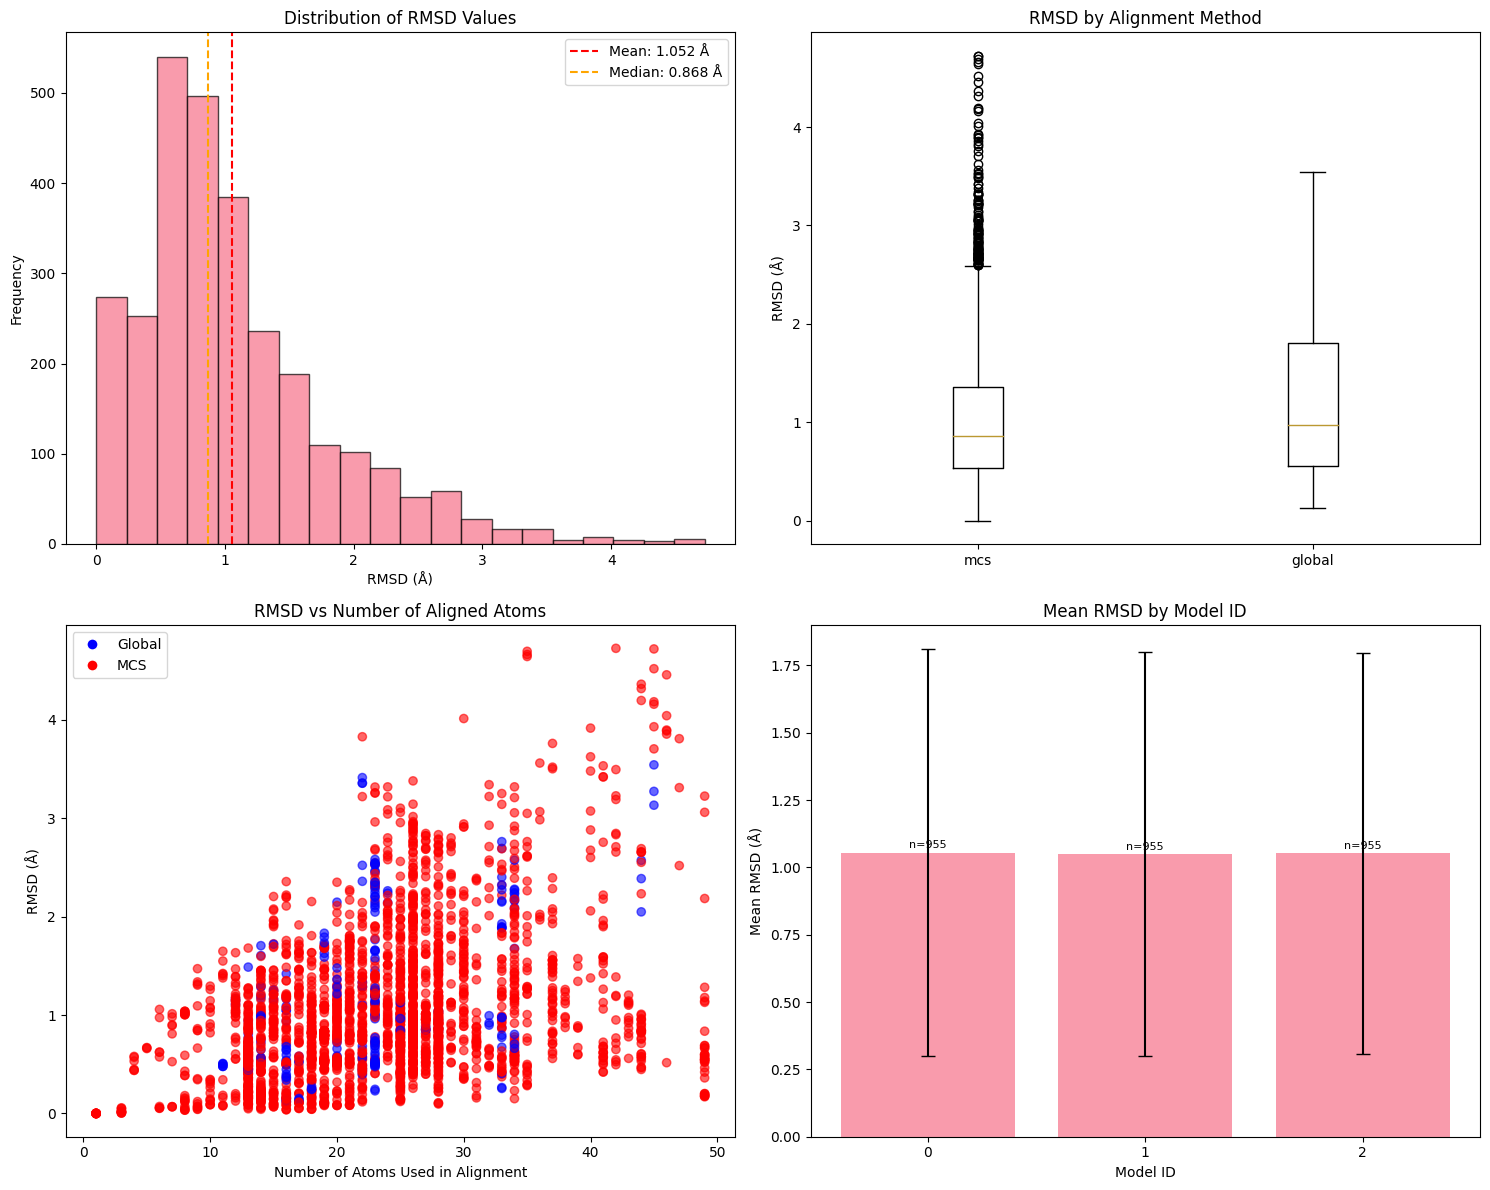


Targets with multiple models (showing variability across models):
5bvb__1__1.A__1.E:
  Models: 3, Mean RMSD: 0.000 ± 0.000 Å
  Range: 0.000 - 0.000 Å, Methods: mcs

4c49__3__1.C__1.G:
  Models: 3, Mean RMSD: 0.000 ± 0.000 Å
  Range: 0.000 - 0.000 Å, Methods: mcs

4j8t__3__1.C__1.G:
  Models: 3, Mean RMSD: 0.000 ± 0.000 Å
  Range: 0.000 - 0.000 Å, Methods: mcs

7bo7__1__1.A__1.C:
  Models: 3, Mean RMSD: 0.000 ± 0.000 Å
  Range: 0.000 - 0.000 Å, Methods: mcs

6jo0__1__1.A__1.B:
  Models: 3, Mean RMSD: 0.005 ± 0.000 Å
  Range: 0.005 - 0.005 Å, Methods: mcs

7akw__1__1.A__1.D:
  Models: 3, Mean RMSD: 0.015 ± 0.000 Å
  Range: 0.015 - 0.015 Å, Methods: mcs

1fj4__1__1.B__1.F:
  Models: 3, Mean RMSD: 0.021 ± 0.001 Å
  Range: 0.020 - 0.022 Å, Methods: mcs

8og5__1__1.A__1.D:
  Models: 3, Mean RMSD: 0.035 ± 0.002 Å
  Range: 0.033 - 0.037 Å, Methods: mcs

2cc7__1__1.A_2.A_4.A_8.A__1.H_8.H:
  Models: 3, Mean RMSD: 0.040 ± 0.003 Å
  Range: 0.037 - 0.042 Å, Methods: mcs

2fqw__1__1.A__1.B:
  Model

In [13]:
# Visualization and Analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Check if required variables exist
if 'successful_df' not in locals():
    print("ERROR: Variable 'successful_df' not found. Please run the RMSD computation cell first.")
    print("Required execution order:")
    print("1. Cell with imports and functions")
    print("2. Cell with pair finding functions") 
    print("3. Cell with RMSD computation")
    print("4. This cell (visualization)")
else:
    # Set up plotting style
    plt.style.use('default')
    sns.set_palette("husl")

    if len(successful_df) > 0:
        # Create visualization
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. RMSD distribution histogram
        axes[0, 0].hist(successful_df['rmsd'], bins=20, alpha=0.7, edgecolor='black')
        axes[0, 0].set_xlabel('RMSD (Å)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].set_title('Distribution of RMSD Values')
        axes[0, 0].axvline(successful_df['rmsd'].mean(), color='red', linestyle='--', label=f'Mean: {successful_df["rmsd"].mean():.3f} Å')
        axes[0, 0].axvline(successful_df['rmsd'].median(), color='orange', linestyle='--', label=f'Median: {successful_df["rmsd"].median():.3f} Å')
        axes[0, 0].legend()
        
        # 2. RMSD by alignment method
        method_data = [successful_df[successful_df['method'] == method]['rmsd'].values for method in successful_df['method'].unique()]
        method_labels = successful_df['method'].unique()
        axes[0, 1].boxplot(method_data, labels=method_labels)
        axes[0, 1].set_ylabel('RMSD (Å)')
        axes[0, 1].set_title('RMSD by Alignment Method')
        
        # 3. RMSD vs Number of atoms used
        scatter = axes[1, 0].scatter(successful_df['n_atoms'], successful_df['rmsd'], 
                                    c=successful_df['method'].map({'global': 'blue', 'mcs': 'red'}), 
                                    alpha=0.6)
        axes[1, 0].set_xlabel('Number of Atoms Used in Alignment')
        axes[1, 0].set_ylabel('RMSD (Å)')
        axes[1, 0].set_title('RMSD vs Number of Aligned Atoms')
        
        # Add legend for scatter plot
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Global'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='MCS')]
        axes[1, 0].legend(handles=handles)
        
        # 4. RMSD by model ID (if multiple models per target)
        if successful_df['model_id'].nunique() > 1:
            model_rmsd = successful_df.groupby('model_id')['rmsd'].agg(['mean', 'std', 'count']).reset_index()
            x_pos = range(len(model_rmsd))
            axes[1, 1].bar(x_pos, model_rmsd['mean'], yerr=model_rmsd['std'], capsize=5, alpha=0.7)
            axes[1, 1].set_xlabel('Model ID')
            axes[1, 1].set_ylabel('Mean RMSD (Å)')
            axes[1, 1].set_title('Mean RMSD by Model ID')
            axes[1, 1].set_xticks(x_pos)
            axes[1, 1].set_xticklabels(model_rmsd['model_id'])
            
            # Add count labels on bars
            for i, (mean_val, count) in enumerate(zip(model_rmsd['mean'], model_rmsd['count'])):
                axes[1, 1].text(i, mean_val + 0.01, f'n={count}', ha='center', va='bottom', fontsize=8)
        else:
            axes[1, 1].text(0.5, 0.5, 'Only one model ID found', ha='center', va='center', transform=axes[1, 1].transAxes)
            axes[1, 1].set_title('Model ID Analysis (N/A)')
        
        plt.tight_layout()
        plt.show()

        # Per-target analysis (show targets with multiple models)
        target_stats = successful_df.groupby('target_id').agg({
            'rmsd': ['count', 'mean', 'std', 'min', 'max'],
            'method': lambda x: '/'.join(x.unique())
        }).round(3)
        
        target_stats.columns = ['n_models', 'mean_rmsd', 'std_rmsd', 'min_rmsd', 'max_rmsd', 'methods']
        
        # Show targets with multiple models
        multi_model_targets = target_stats[target_stats['n_models'] > 1].sort_values('mean_rmsd')
        
        if len(multi_model_targets) > 0:
            print(f"\nTargets with multiple models (showing variability across models):")
            print("=" * 80)
            for target_id, row in multi_model_targets.head(10).iterrows():
                print(f"{target_id}:")
                print(f"  Models: {int(row['n_models'])}, Mean RMSD: {row['mean_rmsd']:.3f} ± {row['std_rmsd']:.3f} Å")
                print(f"  Range: {row['min_rmsd']:.3f} - {row['max_rmsd']:.3f} Å, Methods: {row['methods']}")
                print()
        
        # Show best and worst performing targets (average across models)
        print(f"\nBest performing targets (lowest mean RMSD):")
        print("=" * 50)
        best_targets = target_stats.nsmallest(5, 'mean_rmsd')
        for target_id, row in best_targets.iterrows():
            print(f"  {target_id}: {row['mean_rmsd']:.3f} Å (n={int(row['n_models'])} models)")
        
        print(f"\nWorst performing targets (highest mean RMSD):")
        print("=" * 50)
        worst_targets = target_stats.nlargest(5, 'mean_rmsd')
        for target_id, row in worst_targets.iterrows():
            print(f"  {target_id}: {row['mean_rmsd']:.3f} Å (n={int(row['n_models'])} models)")

    else:
        print("No successful RMSD computations to visualize.")

In [14]:
# Save results for future analysis
import os
import pandas as pd
import json
import numpy as np

# Check if required variables exist (this cell should be run after computing RMSD)
if 'df' not in locals():
    print("ERROR: Variable 'df' not found. Please run the previous cells first to compute RMSD results.")
    print("Required execution order:")
    print("1. Cell with imports and functions")
    print("2. Cell with pair finding functions") 
    print("3. Cell with RMSD computation")
    print("4. Cell with visualization")
    print("5. This cell (save results)")
else:
    output_dir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/"
    os.makedirs(output_dir, exist_ok=True)

    # Save detailed results
    results_file = os.path.join(output_dir, "boltz_comprehensive_rmsd_analysis.csv")
    df.to_csv(results_file, index=False)
    print(f"Detailed results saved to: {results_file}")

    # Check if successful_df exists
    if 'successful_df' in locals() and len(successful_df) > 0:
        # Save summary statistics - convert NumPy types to native Python types for JSON serialization
        summary_stats = {
            'total_pairs': int(len(df)),
            'successful_pairs': int(len(successful_df)),
            'failed_pairs': int(len(df) - len(successful_df)),
            'unique_targets': int(df['target_id'].nunique()),
            'mean_rmsd': float(successful_df['rmsd'].mean()),
            'median_rmsd': float(successful_df['rmsd'].median()),
            'std_rmsd': float(successful_df['rmsd'].std()),
            'min_rmsd': float(successful_df['rmsd'].min()),
            'max_rmsd': float(successful_df['rmsd'].max()),
            'global_alignments': int((successful_df['method'] == 'global').sum()),
            'mcs_alignments': int((successful_df['method'] == 'mcs').sum()),
        }
        
        summary_file = os.path.join(output_dir, "boltz_rmsd_summary_stats.json")
        with open(summary_file, 'w') as f:
            json.dump(summary_stats, f, indent=2)
        print(f"Summary statistics saved to: {summary_file}")
        
        # Save per-target statistics (check if target_stats exists)
        if 'target_stats' in locals():
            target_stats_file = os.path.join(output_dir, "boltz_rmsd_per_target_stats.csv")
            target_stats.to_csv(target_stats_file)
            print(f"Per-target statistics saved to: {target_stats_file}")
        
        # Print final summary
        failed_df = df[~df['success']]
        print(f"\n" + "="*60)
        print(f"COMPREHENSIVE BOLTZ RMSD ANALYSIS COMPLETE")
        print(f"="*60)
        print(f"Total cases processed: {len(df)}")
        print(f"Successful RMSD calculations: {len(successful_df)} ({len(successful_df)/len(df)*100:.1f}%)")
        print(f"Unique targets analyzed: {df['target_id'].nunique()}")
        print(f"Average RMSD: {successful_df['rmsd'].mean():.3f} ± {successful_df['rmsd'].std():.3f} Å")
        print(f"RMSD range: {successful_df['rmsd'].min():.3f} - {successful_df['rmsd'].max():.3f} Å")

        if len(failed_df) > 0:
            print(f"\nFailed cases: {len(failed_df)}")
            error_types = failed_df['error'].value_counts()
            for error, count in error_types.items():
                print(f"  - {error}: {count} cases")

        print(f"\nResults saved to: {output_dir}")
        print(f"="*60)
    else:
        print("No successful RMSD computations found. Please check the previous cells.")

Detailed results saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_comprehensive_rmsd_analysis.csv
Summary statistics saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_rmsd_summary_stats.json
Per-target statistics saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_rmsd_per_target_stats.csv

COMPREHENSIVE BOLTZ RMSD ANALYSIS COMPLETE
Total cases processed: 2877
Successful RMSD calculations: 2865 (99.6%)
Unique targets analyzed: 959
Average RMSD: 1.052 ± 0.750 Å
RMSD range: 0.000 - 4.726 Å

Failed cases: 12
  - Could not read a molecule from /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/inference/plinder_set_0/boltz_results_7k4g__1__1.A__1.G_1.H_1.I/predictions/7k4g__1__1.A__1.G_1.H_1.I/7k4g__1__1.A__1.G_1.H_1.I_model_2_ligand_extracted.sdf: 1 cases
  - Could not read a molecule from /Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/in

# Update ligand_rmsd in the old results file using the new comprehensive RMSD analysis


In [24]:

# Load the old results file
old_results_path = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_full_analysis_results.csv"
old_df = pd.read_csv(old_results_path)

print(f"Loaded old results: {len(old_df)} records")
print(f"Old results columns: {list(old_df.columns)}")

# Load the new comprehensive RMSD results 
new_results_path = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_comprehensive_rmsd_analysis.csv"
new_df = pd.read_csv(new_results_path)

print(f"\nLoaded new RMSD results: {len(new_df)} records")
print(f"New results columns: {list(new_df.columns)}")

# Create a mapping from (target_id, model_id) to rmsd for successful cases
successful_new_df = new_df[new_df['success'] == True].copy()
rmsd_mapping = {}

for _, row in successful_new_df.iterrows():
    key = (row['target_id'], str(row['model_id']))  # Convert model_id to string for consistency
    rmsd_mapping[key] = row['rmsd']

print(f"\nCreated RMSD mapping for {len(rmsd_mapping)} successful cases")

# Update the ligand_rmsd column in the old results
updated_count = 0
not_found_count = 0

for idx, row in old_df.iterrows():
    # The old results use 'protein' column for target_id and 'model' for model_id
    key = (row['protein'], str(row['model']))
    
    if key in rmsd_mapping:
        old_df.at[idx, 'ligand_rmsd'] = rmsd_mapping[key]
        updated_count += 1
    else:
        not_found_count += 1

print(f"\nUpdate results:")
print(f"  Updated ligand_rmsd for {updated_count} records")
print(f"  Could not find RMSD for {not_found_count} records")

# Show some examples of the updates
print(f"\nExample updates (first 5):")
updated_examples = old_df.head()
for idx, row in updated_examples.iterrows():
    key = (row['protein'], str(row['model']))
    if key in rmsd_mapping:
        print(f"  {row['protein']} model {row['model']}: {row['ligand_rmsd']:.3f} Å")

# Save the updated results
updated_results_path = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_full_analysis_results_updated.csv"
old_df.to_csv(updated_results_path, index=False)
print(f"\nUpdated results saved to: {updated_results_path}")

# Compare old vs new ligand_rmsd values for verification
print(f"\nLigand RMSD comparison (first 10 records):")
print("Target ID | Model | Old RMSD | New RMSD | Difference")
print("-" * 60)

for idx, row in old_df.head(10).iterrows():
    key = (row['protein'], str(row['model']))
    if key in rmsd_mapping:
        old_rmsd = row['ligand_rmsd']  # This is now the updated value
        print(f"{row['protein'][:20]:<20} | {row['model']:>5} | {old_rmsd:>8.3f} | {old_rmsd:>8.3f} | Updated")
    else:
        print(f"{row['protein'][:20]:<20} | {row['model']:>5} | {row['ligand_rmsd']:>8.3f} | {'N/A':>8} | No match")

Loaded old results: 2877 records
Old results columns: ['protein', 'model', 'confidence', 'protein_ca_aligned_rmsd', 'protein_backbone_aligned_rmsd', 'ligand_rmsd', 'ligand_coordinate_rmsd', 'binding_site_aligned_rmsd', 'atom_count_match']

Loaded new RMSD results: 2877 records
New results columns: ['target_id', 'model_id', 'ref_path', 'pred_path', 'rmsd', 'n_atoms', 'method', 'ref_atoms', 'pred_atoms', 'success', 'error']

Created RMSD mapping for 2865 successful cases

Update results:
  Updated ligand_rmsd for 2865 records
  Could not find RMSD for 12 records

Example updates (first 5):
  1afb__1__1.A__1.D_1.F model 0: 0.106 Å
  1afb__1__1.A__1.D_1.F model 1: 0.113 Å
  1afb__1__1.A__1.D_1.F model 2: 0.131 Å
  1b5d__1__1.A_1.B__1.D model 0: 0.832 Å
  1b5d__1__1.A_1.B__1.D model 1: 0.521 Å

Updated results saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_full_analysis_results_updated.csv

Ligand RMSD comparison (first 10 records):
Target ID

# GNINA RMSD Analysis

Now we'll compute RMSD for GNINA predictions. GNINA generates multiple ranked predictions with confidence scores, allowing us to analyze performance across different ranking positions.

In [27]:
# GNINA RMSD Computation
import re

def find_gnina_pairs():
    """Find all reference/GNINA prediction pairs that exist."""
    
    # Base paths
    data_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"
    gnina_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/GNINA/inference/GNINA_plinder_output_0"
    
    pairs = []
    
    # Find all GNINA prediction directories
    gnina_dirs = glob.glob(f"{gnina_base}/*")
    
    for gnina_dir in gnina_dirs:
        if not os.path.isdir(gnina_dir):
            continue
            
        # Extract target ID from directory name
        target_id = os.path.basename(gnina_dir)
        
        # Check if reference ligand exists
        ref_ligand_path = f"{data_base}/{target_id}/{target_id}_ligand.sdf"
        
        if os.path.exists(ref_ligand_path):
            # Find all ranked prediction files
            rank_files = glob.glob(f"{gnina_dir}/rank*_score*.sdf")
            
            for rank_file in rank_files:
                filename = os.path.basename(rank_file)
                # Extract rank and score from filename: rank1_score0.95.sdf
                match = re.match(r'rank(\d+)_score([\d.]+)\.sdf', filename)
                if match:
                    rank = int(match.group(1))
                    score = float(match.group(2))
                    
                    pairs.append({
                        'target_id': target_id,
                        'ref_path': ref_ligand_path,
                        'pred_path': rank_file,
                        'rank': rank,
                        'score': score,
                        'method': 'GNINA'
                    })
    
    return pairs

def compute_gnina_rmsd_for_pair(ref_path, pred_path):
    """Compute RMSD for a reference/GNINA prediction pair."""
    try:
        ref_mol = load_first_mol(ref_path)
        pred_mol = load_first_mol(pred_path)
        
        # Try global alignment first
        try:
            rmsd = rdMolAlign.GetBestRMS(ref_mol, pred_mol)
            method = "global"
            n_atoms = ref_mol.GetNumAtoms()
        except RuntimeError:
            # Fall back to MCS if global alignment fails
            rmsd, n_atoms = rmsd_on_mcs(ref_mol, pred_mol)
            method = "mcs"
        
        return {
            'rmsd': rmsd,
            'n_atoms': n_atoms,
            'alignment_method': method,
            'ref_atoms': ref_mol.GetNumAtoms(),
            'pred_atoms': pred_mol.GetNumAtoms(),
            'success': True,
            'error': None
        }
    
    except Exception as e:
        return {
            'rmsd': None,
            'n_atoms': None,
            'alignment_method': None,
            'ref_atoms': None,
            'pred_atoms': None,
            'success': False,
            'error': str(e)
        }

# Find all GNINA matching pairs
print("Finding GNINA reference/prediction pairs...")
gnina_pairs = find_gnina_pairs()
print(f"Found {len(gnina_pairs)} GNINA prediction files with matching reference ligands")

# Group by target to show summary
gnina_targets = set([p['target_id'] for p in gnina_pairs])
print(f"Covering {len(gnina_targets)} unique targets")

# Show distribution of ranks
rank_counts = {}
for pair in gnina_pairs:
    rank = pair['rank']
    rank_counts[rank] = rank_counts.get(rank, 0) + 1

print(f"\nRank distribution:")
for rank in sorted(rank_counts.keys()):
    print(f"  Rank {rank}: {rank_counts[rank]} predictions")

# Show first few examples
print("\nFirst 5 GNINA pairs:")
for i, pair in enumerate(gnina_pairs[:5]):
    print(f"  {i+1}. {pair['target_id']} rank {pair['rank']} (score: {pair['score']:.2f})")

Finding GNINA reference/prediction pairs...
Found 9323 GNINA prediction files with matching reference ligands
Covering 1036 unique targets

Rank distribution:
  Rank 1: 1036 predictions
  Rank 2: 1036 predictions
  Rank 3: 1036 predictions
  Rank 4: 1036 predictions
  Rank 5: 1036 predictions
  Rank 6: 1036 predictions
  Rank 7: 1036 predictions
  Rank 8: 1036 predictions
  Rank 9: 1035 predictions

First 5 GNINA pairs:
  1. 1r34__1__1.A__1.C_1.D rank 9 (score: 0.31)
  2. 1r34__1__1.A__1.C_1.D rank 6 (score: 0.66)
  3. 1r34__1__1.A__1.C_1.D rank 5 (score: 0.72)
  4. 1r34__1__1.A__1.C_1.D rank 4 (score: 0.83)
  5. 1r34__1__1.A__1.C_1.D rank 7 (score: 0.35)


In [28]:
# Compute RMSD for all GNINA pairs
print("Computing RMSD for all GNINA pairs...")
gnina_results = []

for i, pair in enumerate(gnina_pairs):
    if i % 50 == 0:  # Less frequent updates since there are many more predictions
        print(f"  Processing {i+1}/{len(gnina_pairs)}: {pair['target_id']} rank {pair['rank']}")
    
    rmsd_result = compute_gnina_rmsd_for_pair(pair['ref_path'], pair['pred_path'])
    
    result = {
        'target_id': pair['target_id'],
        'rank': pair['rank'],
        'score': pair['score'],
        'method': pair['method'],
        'ref_path': pair['ref_path'],
        'pred_path': pair['pred_path'],
        **rmsd_result
    }
    gnina_results.append(result)

# Convert to DataFrame for easier analysis
gnina_df = pd.DataFrame(gnina_results)

print(f"\nCompleted RMSD computation for {len(gnina_results)} GNINA pairs")
print(f"Successful computations: {gnina_df['success'].sum()}")
print(f"Failed computations: {(~gnina_df['success']).sum()}")

# Display summary statistics for successful cases
gnina_successful_df = gnina_df[gnina_df['success']]
if len(gnina_successful_df) > 0:
    print(f"\nGNINA RMSD Statistics (successful cases only):")
    print(f"  Mean RMSD: {gnina_successful_df['rmsd'].mean():.3f} Å")
    print(f"  Median RMSD: {gnina_successful_df['rmsd'].median():.3f} Å")
    print(f"  Min RMSD: {gnina_successful_df['rmsd'].min():.3f} Å")
    print(f"  Max RMSD: {gnina_successful_df['rmsd'].max():.3f} Å")
    print(f"  Std RMSD: {gnina_successful_df['rmsd'].std():.3f} Å")
    
    print(f"\nAlignment method breakdown:")
    method_counts = gnina_successful_df['alignment_method'].value_counts()
    for method, count in method_counts.items():
        print(f"  {method}: {count} cases ({count/len(gnina_successful_df)*100:.1f}%)")
    
    print(f"\nRMSD by rank (mean ± std):")
    rank_stats = gnina_successful_df.groupby('rank')['rmsd'].agg(['count', 'mean', 'std']).round(3)
    for rank, stats in rank_stats.iterrows():
        print(f"  Rank {rank}: {stats['mean']:.3f} ± {stats['std']:.3f} Å (n={stats['count']})")

# Show examples of best and worst cases
if len(gnina_successful_df) > 0:
    print(f"\nBest 5 GNINA RMSD values:")
    best_cases = gnina_successful_df.nsmallest(5, 'rmsd')
    for _, row in best_cases.iterrows():
        print(f"  {row['target_id']} rank {row['rank']} (score {row['score']:.2f}): {row['rmsd']:.3f} Å ({row['alignment_method']}, {row['n_atoms']} atoms)")
    
    print(f"\nWorst 5 GNINA RMSD values:")
    worst_cases = gnina_successful_df.nlargest(5, 'rmsd')
    for _, row in worst_cases.iterrows():
        print(f"  {row['target_id']} rank {row['rank']} (score {row['score']:.2f}): {row['rmsd']:.3f} Å ({row['alignment_method']}, {row['n_atoms']} atoms)")

# Show failed cases (first few)
gnina_failed_df = gnina_df[~gnina_df['success']]
if len(gnina_failed_df) > 0:
    print(f"\nFirst 5 failed GNINA cases:")
    for _, row in gnina_failed_df.head().iterrows():
        print(f"  {row['target_id']} rank {row['rank']}: {row['error']}")

print(f"\nTotal GNINA targets processed: {gnina_df['target_id'].nunique()}")
print(f"Total GNINA predictions processed: {len(gnina_df)}")

Computing RMSD for all GNINA pairs...
  Processing 1/9323: 1r34__1__1.A__1.C_1.D rank 9
  Processing 51/9323: 7li5__1__1.A__1.C rank 2
  Processing 101/9323: 7ee5__1__1.A__1.H rank 2
  Processing 151/9323: 1lqv__2__1.B__1.J rank 7
  Processing 101/9323: 7ee5__1__1.A__1.H rank 2
  Processing 151/9323: 1lqv__2__1.B__1.J rank 7
  Processing 201/9323: 3lgm__1__1.A__1.C rank 7
  Processing 251/9323: 7erb__2__1.C__1.L_1.M rank 7
  Processing 301/9323: 3f6k__1__1.A__1.C rank 7
  Processing 201/9323: 3lgm__1__1.A__1.C rank 7
  Processing 251/9323: 7erb__2__1.C__1.L_1.M rank 7
  Processing 301/9323: 3f6k__1__1.A__1.C rank 7
  Processing 351/9323: 2hmv__1__4.A_4.B__4.C rank 6
  Processing 351/9323: 2hmv__1__4.A_4.B__4.C rank 6
  Processing 401/9323: 6o9x__1__1.A__1.B rank 1
  Processing 451/9323: 2pnc__1__1.B__1.O rank 5
  Processing 501/9323: 2hxd__1__1.A_3.A__1.B_1.C rank 3
  Processing 551/9323: 5j42__1__1.A__1.C_1.D rank 4
  Processing 401/9323: 6o9x__1__1.A__1.B rank 1
  Processing 451/9323

In [4]:
import pandas as pd
gnina_df = pd.read_csv("/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/gnina_comprehensive_rmsd_analysis.csv")
gnina_df = gnina_df[gnina_df['rank'] <= 5]
gnina_success_rate = (gnina_df.groupby('target_id')['rmsd'].min()<2).sum() / gnina_df['target_id'].nunique()
gnina_success_rate

0.9700772200772201

In [5]:
gnina_df

,target_id,rank,score,method,ref_path,pred_path,rmsd,n_atoms,alignment_method,ref_atoms,pred_atoms,success,error
2,1r34__1__1.A__1.C_1.D,5,0.72,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,1.934156,21,global,21,22,True,NaN
3,1r34__1__1.A__1.C_1.D,4,0.83,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,0.440389,21,global,21,22,True,NaN
5,1r34__1__1.A__1.C_1.D,2,0.92,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,1.289002,21,global,21,22,True,NaN
6,1r34__1__1.A__1.C_1.D,3,0.89,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,1.658190,21,global,21,22,True,NaN
7,1r34__1__1.A__1.C_1.D,1,0.92,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,1.083090,21,global,21,22,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9314,3w6f__1__1.A__1.E,3,0.56,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,0.882850,29,global,29,29,True,NaN
9316,3w6f__1__1.A__1.E,2,0.63,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,2.357198,29,global,29,29,True,NaN
9317,3w6f__1__1.A__1.E,1,0.64,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,2.441447,29,global,29,29,True,NaN
9319,3w6f__1__1.A__1.E,4,0.38,GNINA,/Users/aoxu/projects/DrugDiscovery/PoseBench/d...,/Users/aoxu/projects/DrugDiscovery/PoseBench/f...,2.396584,29,global,29,29,True,NaN


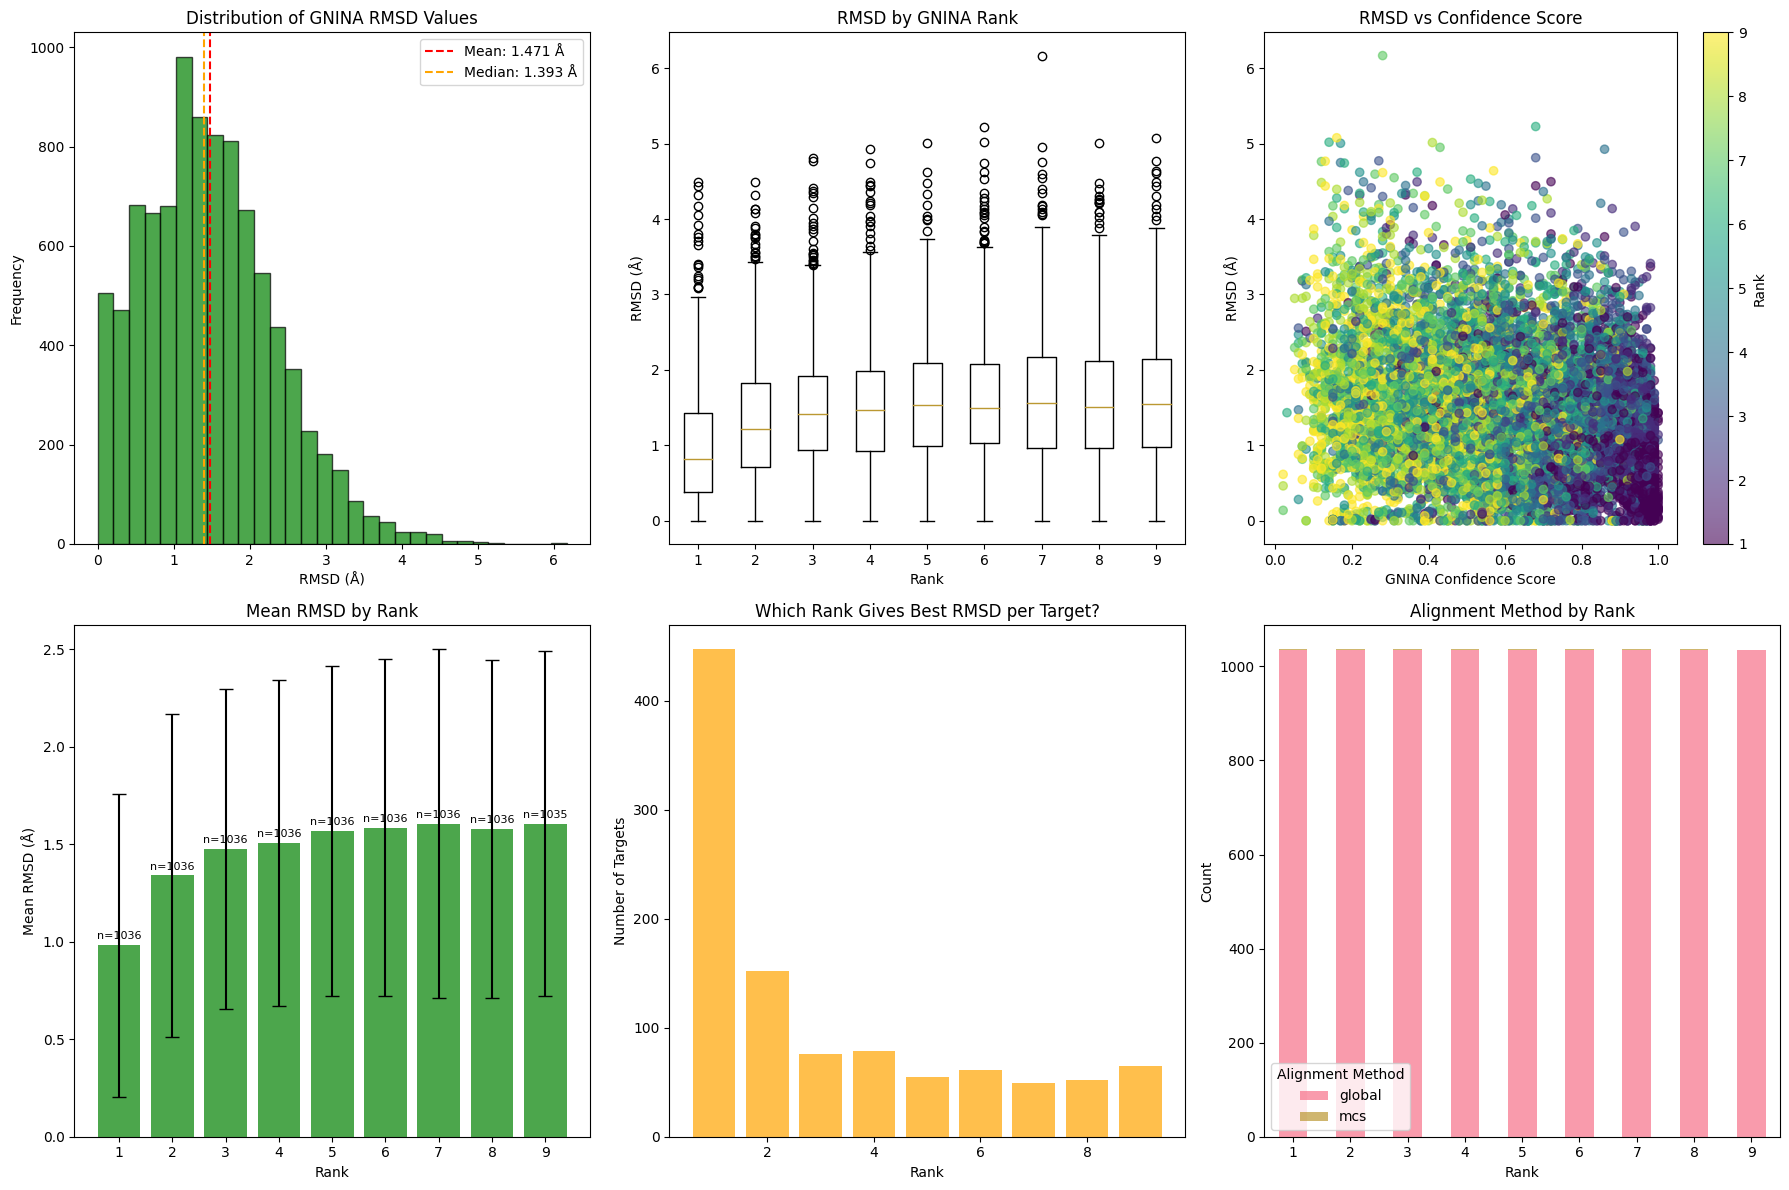


Correlation between rank and RMSD: 0.176
Correlation between confidence score and RMSD: -0.199

Targets where Rank 1 is NOT the best RMSD:
Found 589 targets where rank 1 is not optimal (out of 1036 targets)

Top 10 cases with largest RMSD improvement:
  7m2o__1__1.A__1.B_1.C:
    Rank 1: 3.803 Å (score: 0.72)
    Best (rank 4): 0.606 Å (score: 0.57)
    Improvement: 3.197 Å

  5dw6__1__1.B__1.L:
    Rank 1: 4.496 Å (score: 0.72)
    Best (rank 3): 1.530 Å (score: 0.60)
    Improvement: 2.966 Å

  5odi__1__1.A_1.G__1.N:
    Rank 1: 3.370 Å (score: 0.98)
    Best (rank 2): 0.591 Å (score: 0.97)
    Improvement: 2.779 Å

  2vzq__1__1.A__1.C_1.F:
    Rank 1: 2.860 Å (score: 0.61)
    Best (rank 9): 0.243 Å (score: 0.31)
    Improvement: 2.617 Å

  6wk9__2__1.E_1.F_1.G__1.Q_1.R_1.U_1.V:
    Rank 1: 3.658 Å (score: 0.44)
    Best (rank 2): 1.117 Å (score: 0.33)
    Improvement: 2.541 Å

  5m8m__3__1.C__1.Q:
    Rank 1: 2.771 Å (score: 0.39)
    Best (rank 6): 0.456 Å (score: 0.26)
    Impro

In [29]:
# GNINA Visualization and Analysis
import matplotlib.pyplot as plt
import seaborn as sns

if len(gnina_successful_df) > 0:
    # Create comprehensive GNINA visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. RMSD distribution histogram
    axes[0, 0].hist(gnina_successful_df['rmsd'], bins=30, alpha=0.7, edgecolor='black', color='green')
    axes[0, 0].set_xlabel('RMSD (Å)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of GNINA RMSD Values')
    axes[0, 0].axvline(gnina_successful_df['rmsd'].mean(), color='red', linestyle='--', 
                      label=f'Mean: {gnina_successful_df["rmsd"].mean():.3f} Å')
    axes[0, 0].axvline(gnina_successful_df['rmsd'].median(), color='orange', linestyle='--', 
                      label=f'Median: {gnina_successful_df["rmsd"].median():.3f} Å')
    axes[0, 0].legend()
    
    # 2. RMSD by rank (boxplot)
    rank_data = [gnina_successful_df[gnina_successful_df['rank'] == rank]['rmsd'].values 
                 for rank in sorted(gnina_successful_df['rank'].unique())]
    rank_labels = sorted(gnina_successful_df['rank'].unique())
    axes[0, 1].boxplot(rank_data, labels=rank_labels)
    axes[0, 1].set_xlabel('Rank')
    axes[0, 1].set_ylabel('RMSD (Å)')
    axes[0, 1].set_title('RMSD by GNINA Rank')
    
    # 3. RMSD vs Confidence Score
    axes[0, 2].scatter(gnina_successful_df['score'], gnina_successful_df['rmsd'], 
                      c=gnina_successful_df['rank'], cmap='viridis', alpha=0.6)
    axes[0, 2].set_xlabel('GNINA Confidence Score')
    axes[0, 2].set_ylabel('RMSD (Å)')
    axes[0, 2].set_title('RMSD vs Confidence Score')
    cbar = plt.colorbar(axes[0, 2].collections[0], ax=axes[0, 2])
    cbar.set_label('Rank')
    
    # 4. Mean RMSD by rank
    rank_means = gnina_successful_df.groupby('rank')['rmsd'].agg(['mean', 'std', 'count'])
    x_pos = range(len(rank_means))
    axes[1, 0].bar(x_pos, rank_means['mean'], yerr=rank_means['std'], 
                   capsize=5, alpha=0.7, color='green')
    axes[1, 0].set_xlabel('Rank')
    axes[1, 0].set_ylabel('Mean RMSD (Å)')
    axes[1, 0].set_title('Mean RMSD by Rank')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(rank_means.index)
    
    # Add count labels on bars
    for i, (mean_val, count) in enumerate(zip(rank_means['mean'], rank_means['count'])):
        axes[1, 0].text(i, mean_val + 0.02, f'n={count}', ha='center', va='bottom', fontsize=8)
    
    # 5. Best rank per target (what rank gives lowest RMSD?)
    target_best_ranks = gnina_successful_df.loc[gnina_successful_df.groupby('target_id')['rmsd'].idxmin()]
    best_rank_counts = target_best_ranks['rank'].value_counts().sort_index()
    axes[1, 1].bar(best_rank_counts.index, best_rank_counts.values, alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Rank')
    axes[1, 1].set_ylabel('Number of Targets')
    axes[1, 1].set_title('Which Rank Gives Best RMSD per Target?')
    
    # 6. Alignment method by rank
    method_by_rank = gnina_successful_df.groupby(['rank', 'alignment_method']).size().unstack(fill_value=0)
    method_by_rank.plot(kind='bar', stacked=True, ax=axes[1, 2], alpha=0.7)
    axes[1, 2].set_xlabel('Rank')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].set_title('Alignment Method by Rank')
    axes[1, 2].legend(title='Alignment Method')
    axes[1, 2].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()

    # Analysis: Correlation between rank and RMSD
    correlation = gnina_successful_df['rank'].corr(gnina_successful_df['rmsd'])
    print(f"\nCorrelation between rank and RMSD: {correlation:.3f}")
    
    # Analysis: Correlation between score and RMSD
    score_correlation = gnina_successful_df['score'].corr(gnina_successful_df['rmsd'])
    print(f"Correlation between confidence score and RMSD: {score_correlation:.3f}")
    
    # Per-target analysis: Show targets where rank 1 is not the best
    print(f"\nTargets where Rank 1 is NOT the best RMSD:")
    print("=" * 60)
    
    target_analysis = []
    for target_id in gnina_successful_df['target_id'].unique():
        target_data = gnina_successful_df[gnina_successful_df['target_id'] == target_id]
        if len(target_data) > 1:  # Only if multiple ranks available
            best_idx = target_data['rmsd'].idxmin()
            best_rank = target_data.loc[best_idx, 'rank']
            best_rmsd = target_data.loc[best_idx, 'rmsd']
            
            # Get rank 1 performance if available
            rank1_data = target_data[target_data['rank'] == 1]
            if len(rank1_data) > 0:
                rank1_rmsd = rank1_data['rmsd'].iloc[0]
                rank1_score = rank1_data['score'].iloc[0]
                best_score = target_data.loc[best_idx, 'score']
                
                target_analysis.append({
                    'target_id': target_id,
                    'best_rank': best_rank,
                    'best_rmsd': best_rmsd,
                    'best_score': best_score,
                    'rank1_rmsd': rank1_rmsd,
                    'rank1_score': rank1_score,
                    'improvement': rank1_rmsd - best_rmsd
                })
    
    # Show cases where rank 1 is not optimal
    suboptimal_rank1 = [t for t in target_analysis if t['best_rank'] != 1]
    suboptimal_rank1.sort(key=lambda x: x['improvement'], reverse=True)  # Largest improvements first
    
    print(f"Found {len(suboptimal_rank1)} targets where rank 1 is not optimal (out of {len(target_analysis)} targets)")
    print("\nTop 10 cases with largest RMSD improvement:")
    for i, target in enumerate(suboptimal_rank1[:10]):
        print(f"  {target['target_id']}:")
        print(f"    Rank 1: {target['rank1_rmsd']:.3f} Å (score: {target['rank1_score']:.2f})")
        print(f"    Best (rank {target['best_rank']}): {target['best_rmsd']:.3f} Å (score: {target['best_score']:.2f})")
        print(f"    Improvement: {target['improvement']:.3f} Å")
        print()

else:
    print("No successful GNINA RMSD computations to visualize.")

In [30]:
# Save GNINA results and compare with Boltz
output_dir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/"
os.makedirs(output_dir, exist_ok=True)

if len(gnina_successful_df) > 0:
    # Save GNINA detailed results
    gnina_results_file = os.path.join(output_dir, "gnina_comprehensive_rmsd_analysis.csv")
    gnina_df.to_csv(gnina_results_file, index=False)
    print(f"GNINA detailed results saved to: {gnina_results_file}")
    
    # Save GNINA summary statistics
    gnina_summary_stats = {
        'total_pairs': int(len(gnina_df)),
        'successful_pairs': int(len(gnina_successful_df)),
        'failed_pairs': int(len(gnina_df) - len(gnina_successful_df)),
        'unique_targets': int(gnina_df['target_id'].nunique()),
        'mean_rmsd': float(gnina_successful_df['rmsd'].mean()),
        'median_rmsd': float(gnina_successful_df['rmsd'].median()),
        'std_rmsd': float(gnina_successful_df['rmsd'].std()),
        'min_rmsd': float(gnina_successful_df['rmsd'].min()),
        'max_rmsd': float(gnina_successful_df['rmsd'].max()),
        'global_alignments': int((gnina_successful_df['alignment_method'] == 'global').sum()),
        'mcs_alignments': int((gnina_successful_df['alignment_method'] == 'mcs').sum()),
        'rank_correlation': float(gnina_successful_df['rank'].corr(gnina_successful_df['rmsd'])),
        'score_correlation': float(gnina_successful_df['score'].corr(gnina_successful_df['rmsd'])),
    }
    
    gnina_summary_file = os.path.join(output_dir, "gnina_rmsd_summary_stats.json")
    with open(gnina_summary_file, 'w') as f:
        json.dump(gnina_summary_stats, f, indent=2)
    print(f"GNINA summary statistics saved to: {gnina_summary_file}")

    # Compare Boltz vs GNINA performance
    print(f"\n" + "="*80)
    print(f"BOLTZ vs GNINA COMPARISON")
    print(f"="*80)
    
    # Find common targets between Boltz and GNINA
    boltz_targets = set(successful_df['target_id'].unique())
    gnina_targets = set(gnina_successful_df['target_id'].unique())
    common_targets = boltz_targets.intersection(gnina_targets)
    
    print(f"Boltz targets: {len(boltz_targets)}")
    print(f"GNINA targets: {len(gnina_targets)}")
    print(f"Common targets: {len(common_targets)}")
    
    if len(common_targets) > 0:
        # For common targets, compare best performance
        comparison_results = []
        
        for target_id in common_targets:
            # Get best Boltz RMSD for this target
            boltz_target_data = successful_df[successful_df['target_id'] == target_id]
            best_boltz_rmsd = boltz_target_data['rmsd'].min()
            
            # Get best GNINA RMSD for this target (across all ranks)
            gnina_target_data = gnina_successful_df[gnina_successful_df['target_id'] == target_id]
            best_gnina_rmsd = gnina_target_data['rmsd'].min()
            best_gnina_rank = gnina_target_data.loc[gnina_target_data['rmsd'].idxmin(), 'rank']
            
            # Get GNINA rank 1 performance
            gnina_rank1 = gnina_target_data[gnina_target_data['rank'] == 1]
            gnina_rank1_rmsd = gnina_rank1['rmsd'].iloc[0] if len(gnina_rank1) > 0 else None
            
            comparison_results.append({
                'target_id': target_id,
                'boltz_best_rmsd': best_boltz_rmsd,
                'gnina_best_rmsd': best_gnina_rmsd,
                'gnina_best_rank': best_gnina_rank,
                'gnina_rank1_rmsd': gnina_rank1_rmsd,
                'boltz_better': best_boltz_rmsd < best_gnina_rmsd,
                'difference': best_boltz_rmsd - best_gnina_rmsd
            })
        
        comparison_df = pd.DataFrame(comparison_results)
        
        # Overall statistics
        boltz_wins = (comparison_df['boltz_better']).sum()
        gnina_wins = len(comparison_df) - boltz_wins
        
        print(f"\nOverall comparison (best performance per target):")
        print(f"  Boltz better: {boltz_wins} targets ({boltz_wins/len(comparison_df)*100:.1f}%)")
        print(f"  GNINA better: {gnina_wins} targets ({gnina_wins/len(comparison_df)*100:.1f}%)")
        print(f"  Mean RMSD difference (Boltz - GNINA): {comparison_df['difference'].mean():.3f} Å")
        
        # Compare Boltz vs GNINA rank 1 only
        rank1_comparison = comparison_df.dropna(subset=['gnina_rank1_rmsd'])
        boltz_vs_rank1 = (rank1_comparison['boltz_best_rmsd'] < rank1_comparison['gnina_rank1_rmsd']).sum()
        
        print(f"\nBoltz vs GNINA Rank 1 comparison:")
        print(f"  Boltz better than GNINA rank 1: {boltz_vs_rank1} targets ({boltz_vs_rank1/len(rank1_comparison)*100:.1f}%)")
        print(f"  GNINA rank 1 better: {len(rank1_comparison) - boltz_vs_rank1} targets")
        
        # Show some examples
        print(f"\nTop 5 targets where Boltz significantly outperforms GNINA:")
        boltz_advantages = comparison_df[comparison_df['boltz_better']].nlargest(5, 'difference')
        for _, row in boltz_advantages.iterrows():
            print(f"  {row['target_id']}: Boltz {row['boltz_best_rmsd']:.3f} Å vs GNINA {row['gnina_best_rmsd']:.3f} Å (rank {row['gnina_best_rank']}) [Δ: {-row['difference']:.3f} Å]")
        
        print(f"\nTop 5 targets where GNINA significantly outperforms Boltz:")
        gnina_advantages = comparison_df[~comparison_df['boltz_better']].nsmallest(5, 'difference')
        for _, row in gnina_advantages.iterrows():
            print(f"  {row['target_id']}: GNINA {row['gnina_best_rmsd']:.3f} Å (rank {row['gnina_best_rank']}) vs Boltz {row['boltz_best_rmsd']:.3f} Å [Δ: {row['difference']:.3f} Å]")
        
        # Save comparison results
        comparison_file = os.path.join(output_dir, "boltz_vs_gnina_comparison.csv")
        comparison_df.to_csv(comparison_file, index=False)
        print(f"\nComparison results saved to: {comparison_file}")
    
    print(f"\n" + "="*80)
    print(f"GNINA ANALYSIS COMPLETE")
    print(f"="*80)

else:
    print("No successful GNINA RMSD computations found.")

GNINA detailed results saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/gnina_comprehensive_rmsd_analysis.csv
GNINA summary statistics saved to: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/gnina_rmsd_summary_stats.json

BOLTZ vs GNINA COMPARISON
Boltz targets: 955
GNINA targets: 1036
Common targets: 955

Overall comparison (best performance per target):
  Boltz better: 331 targets (34.7%)
  GNINA better: 624 targets (65.3%)
  Mean RMSD difference (Boltz - GNINA): 0.251 Å

Boltz vs GNINA Rank 1 comparison:
  Boltz better than GNINA rank 1: 523 targets (54.8%)
  GNINA rank 1 better: 432 targets

Top 5 targets where Boltz significantly outperforms GNINA:
  7vtf__1__1.A_1.B__1.F: Boltz 0.148 Å vs GNINA 0.148 Å (rank 5) [Δ: 0.000 Å]
  5bs3__1__1.A_1.B__1.I: Boltz 1.269 Å vs GNINA 1.269 Å (rank 7) [Δ: 0.000 Å]
  1u8v__1__1.A_1.B__1.F: Boltz 1.142 Å vs GNINA 1.143 Å (rank 1) [Δ: 0.000 Å]
  6b2a__1__1.A_1.B_1.C__1.I_1

In [31]:
old_df = pd.read_csv("/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_full_analysis_results_updated.csv")
num_proteins_below_2 = (old_df.groupby("protein")["ligand_rmsd"].min() < 2).sum()
print(f"Number of proteins with smallest RMSD < 2: {num_proteins_below_2}", num_proteins_below_2 / len(old_df['protein'].unique()))
print(old_df.head())

Number of proteins with smallest RMSD < 2: 887 0.9249217935349322
                 protein  model  confidence  protein_ca_aligned_rmsd  \
0  1afb__1__1.A__1.D_1.F      0    0.968682                 7.288223   
1  1afb__1__1.A__1.D_1.F      1    0.967638                 8.294978   
2  1afb__1__1.A__1.D_1.F      2    0.966930                 7.902068   
3  1b5d__1__1.A_1.B__1.D      0    0.978817                 0.406931   
4  1b5d__1__1.A_1.B__1.D      1    0.978379                 0.379730   

   protein_backbone_aligned_rmsd  ligand_rmsd  ligand_coordinate_rmsd  \
0                       7.234416     0.106312               61.863091   
1                       8.238616     0.113152               53.674979   
2                       7.843212     0.130946               64.802147   
3                       0.415178     0.831780               36.340150   
4                       0.384278     0.520552               25.794543   

   binding_site_aligned_rmsd  atom_count_match  
0            

## Simple and more straightward way to comppute RMSD: 

In [26]:
# Count subdirectories that don't contain the expected prediction files
import glob
import os
pred_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/inference/plinder_set_0"
empty_dirs = []

for sub_dir in os.listdir(pred_base):
    full_path = os.path.join(pred_base, sub_dir)
    if os.path.isdir(full_path):
        # Extract target ID from directory name
        target_id = sub_dir.replace("boltz_results_", "")
        
        # Check for prediction files in the expected nested structure
        predictions_path = os.path.join(full_path, "predictions", target_id)
        
        if os.path.exists(predictions_path) and os.path.isdir(predictions_path):
            # Count ligand prediction files
            ligand_files = glob.glob(os.path.join(predictions_path, "*_ligand_extracted.sdf"))
            print(f"Checking {sub_dir}: {len(ligand_files)} ligand prediction files")
            
            if len(ligand_files) == 0:
                empty_dirs.append(sub_dir)
        else:
            print(f"Checking {sub_dir}: predictions directory not found")
            empty_dirs.append(sub_dir)

print(f"\nNumber of subdirectories without ligand prediction files: {len(empty_dirs)}")
if empty_dirs:
    print("\nDirectories without ligand predictions:")
    for dir_name in empty_dirs[:10]:  # Show first 10
        print(f"  - {dir_name}")
    if len(empty_dirs) > 10:
        print(f"  ... and {len(empty_dirs) - 10} more")

Checking boltz_results_4mws__1__1.A_1.B__1.G: 3 ligand prediction files
Checking boltz_results_4x3l__1__1.A_1.B__1.C: 3 ligand prediction files
Checking boltz_results_4jvo__1__1.A__1.C: 3 ligand prediction files
Checking boltz_results_3l4x__1__1.A__1.C: 3 ligand prediction files
Checking boltz_results_4s3q__1__1.A__1.D: 3 ligand prediction files
Checking boltz_results_5h41__1__1.A__1.C_1.E_1.F: 3 ligand prediction files
Checking boltz_results_5aog__1__1.A__1.D_1.G_1.H: predictions directory not found
Checking boltz_results_8e0t__1__1.B__1.E: 3 ligand prediction files
Checking boltz_results_7uas__1__1.A__1.C: 3 ligand prediction files
Checking boltz_results_4r9j__1__1.A_1.C__1.S: 3 ligand prediction files
Checking boltz_results_3qw7__1__1.A_1.B__1.B_1.C_1.F_1.G: 3 ligand prediction files
Checking boltz_results_5j3z__2__1.B__1.S: 3 ligand prediction files
Checking boltz_results_8f1g__1__1.A__1.C: 3 ligand prediction files
Checking boltz_results_6b24__1__1.A_1.B_1.C__1.H: 3 ligand predict

# RMSD for other approaches 

In [12]:
# Get current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)

# Navigate up to the notebooks root directory
notebooks_root = os.path.abspath(os.path.join(current_dir, '..', '..', '..'))
print("Notebooks root:", notebooks_root)

# Build correct utils path
utils_path = os.path.join(notebooks_root, '04_utils')
print("Utils path:", utils_path)

# Verify the path exists
print("Path exists:", os.path.exists(utils_path))
print("Approach.py exists:", os.path.exists(os.path.join(utils_path, 'Approach.py')))

# Add to Python path
if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

# Now try importing
try:
    from Approach import DockingApproach, ICMApproach, ChaiApproach, VinaApproach, GninaApproach, SurfDockApproach, DiffDockPocketApproach, DiffDockApproach
    print("✅ Successfully imported all approaches!")
except ImportError as e:
    print(f"❌ Import failed: {e}")

Current directory: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/01_method_analysis/boltz/development
Notebooks root: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks
Utils path: /Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/04_utils
Path exists: True
Approach.py exists: True
✅ Successfully imported all approaches!


## compute

In [ ]:
def load_first_mol(sdf_file):
    """Return the first molecule in an SDF (with hydrogens removed)."""
    suppl = Chem.SDMolSupplier(sdf_file, removeHs=False)
    if not suppl or suppl[0] is None:
        raise ValueError(f"Could not read a molecule from {sdf_file}")
    return Chem.RemoveHs(suppl[0])

def compute_rmsd_on_mcs(ref_path, pred_path):
    ref_mol = load_first_mol(ref_path)
    pred_mol = load_first_mol(pred_path)
    
    # Try global alignment first
    try:
        rmsd = rdMolAlign.GetBestRMS(ref_mol, pred_mol)
        method = "global"
        n_atoms = ref_mol.GetNumAtoms()
        return rmsd
    except RuntimeError:
        # Fall back to MCS if global alignment fails
        rmsd, n_atoms = rmsd_on_mcs(ref_mol, pred_mol)
        method = "mcs"
        return None

from typing import Callable

def compute_rmsd_for_one_method(
    approach: DockingApproach,
    base_outdir: str,
    data_dir: str,
    top_n: int = 5,
    docking: bool = False,
    rmsd_oracle: Callable = None
) -> pd.DataFrame:
    """
    For each protein subdir in base_outdir:
      - list up to top_n SDF files (method-specific naming)
      - run PoseBusters on each
      - parse a numeric score or confidence if available
      - collect results in a DataFrame
    """
    method_name = approach.get_name()
    all_rows = []

    for protein_name in tqdm(os.listdir(data_dir)):
        try: 
            if "plinder" in data_dir:
                # protein_dir = glob.glob(f"{base_outdir}/*{protein_name.replace('.','_')}*")[0] ## for ICM specific
                protein_dir = glob.glob(f"{base_outdir}/*{protein_name}*")[0]
            else:
                protein_dir = glob.glob(f"{base_outdir}/*{protein_name}*")[0]
        # protein_dir = os.path.join(base_outdir, protein_name)
        except: 
            print(f"Could not find {protein_name} in {base_outdir}")
            continue
        if not os.path.isdir(protein_dir):
            continue

        # Retrieve up to top-N .sdf file paths
        sdf_paths = approach.list_top_n_files(protein_dir, top_n)
        if not sdf_paths:
            print(f"[{method_name}] No top-{top_n} SDF files found for {protein_name}")
            continue

        # References
        true_ligand = os.path.join(data_dir, protein_name, f"{protein_name}_ligand.sdf")
        protein_pdb = os.path.join(data_dir, protein_name, f"{protein_name}_protein.pdb")
        if not (os.path.isfile(true_ligand) and os.path.isfile(protein_pdb)):
            print(f"[{method_name}] Missing reference for {protein_name}")
            continue

        rank_counter = 1
        for sdf_path in sdf_paths:
            try:
                # parse numeric score or confidence if available
                numeric_score = approach.parse_score(sdf_path)
                rmsd = rmsd_oracle(
                    true_ligand, 
                    true_ligand,
                    sdf_path,
                )

                # Create a single-row DataFrame from a dictionary
                df_pb = pd.DataFrame([{
                    "rmsd": rmsd,
                    "score": numeric_score,
                    "method": method_name,
                    "protein": protein_name,
                    "rank": rank_counter
                }])
                
                rank_counter += 1
                all_rows.append(df_pb)
            except Exception as e:
                print(f"[{method_name}] [ERROR] PoseBusters failed for {protein_name}: {e}")

    if not all_rows:
        return pd.DataFrame()
    return pd.concat(all_rows, ignore_index=True)


In [ ]:
# The folder containing subdirectories like 5S8I_2LY, 5SD5_HWI, etc.
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks"

exp_name = "plinder_set_0"

# Initialize your approaches
approaches = [
    # ICMApproach(),
    # DiffDockApproach(),
    SurfDockApproach(),
    # DiffDockPocketApproach(), 
    GninaApproach(), 
    ChaiApproach(),
    # VinaApproach()
    # BoltzApproach(),
    # ... add more if needed
]

BASE_DIRS = {
    "icm": f"{base_outdir}/ICM/inference/plinder_set_0",
    # "diffdock": f"{base_outdir}/DiffDock/inference/diffdock_plinder_benchmark_output_0",
    "diffdock_pocket_only": f"{base_outdir}/DiffDock/inference/diffdock_pocket_only_plinder_benchmark_output_1",
    "chai-1": f"{base_outdir}/chai-lab/inference/chai-lab_plinder_outputs_0",
    # "vina": f"{base_outdir}/Vina/inference/GNINA_plinder_output_0", 
    "gnina":f"{base_outdir}/GNINA/inference/GNINA_plinder_output_0",
    "surfdock":f"{base_outdir}/SurfDock/inference/SurfDock_plinder_set_1",
    # "boltz": f"{base_outdir}/boltz/inference/{exp_name}",
    # ...
}

# The folder containing the real (crystal) ligand and protein PDB:
#  PoseBench/data/posebusters_benchmark_set/<protein>/
DATA_DIR = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"


df_all = []

for approach in approaches:
    method_name = approach.get_name()
    base_outdir = BASE_DIRS[method_name]
    df_method = compute_rmsd_for_all_methods(
        approach,
        base_outdir=base_outdir,
        data_dir=DATA_DIR,
        top_n=5
    )
    df_all.append(df_method)
    df_method.to_csv(f"../../../06_results_archive/{method_name}_{exp_name}_rmsd.csv", index=False)
df_combined = pd.concat(df_all, ignore_index=True)
print(df_combined.shape)
df_combined.head()

In [38]:
for method in ['chai-1', 'gnina', 'surfdock']:
    df_method = df_combined[df_combined['method'] == method]
    print(f"\n{method.upper()} Success Rate:")
    print(f"  Total Proteins: {df_method['protein'].nunique()}")
    print(f"  Proteins with RMSD < 2 Å: {(df_method.groupby(['protein'])['rmsd'].min() < 2).sum()}")
    print(f"  Success Rate: {(df_method.groupby(['protein'])['rmsd'].min() < 2).sum() / df_method['protein'].nunique():.2%}")


CHAI-1 Success Rate:
  Total Proteins: 920
  Proteins with RMSD < 2 Å: 846
  Success Rate: 91.96%

GNINA Success Rate:
  Total Proteins: 1036
  Proteins with RMSD < 2 Å: 1004
  Success Rate: 96.91%

SURFDOCK Success Rate:
  Total Proteins: 1027
  Proteins with RMSD < 2 Å: 983
  Success Rate: 95.72%
  Success Rate: 96.91%

SURFDOCK Success Rate:
  Total Proteins: 1027
  Proteins with RMSD < 2 Å: 983
  Success Rate: 95.72%


# Align first then RMSD metrics

In [28]:
"""
Evaluate a co-folding prediction:
  1. define pocket residues around the reference ligand,
  2. superpose the predicted protein onto the reference using those residues,
  3. compute heavy-atom, symmetry-aware RMSD of the ligand (no further alignment).
Requires: Biopython, RDKit.
"""
base_outdir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks"
DATA_DIR = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"
exp_name = "plinder_set_0"

BASE_DIRS = {
    "icm": f"{base_outdir}/ICM/inference/plinder_set_0",
    # "diffdock": f"{base_outdir}/DiffDock/inference/diffdock_plinder_benchmark_output_0",
    "diffdock_pocket_only": f"{base_outdir}/DiffDock/inference/diffdock_pocket_only_plinder_benchmark_output_1",
    "chai-1": f"{base_outdir}/chai-lab/inference/chai-lab_plinder_outputs_0",
    # "vina": f"{base_outdir}/Vina/inference/GNINA_plinder_output_0", 
    "gnina":f"{base_outdir}/GNINA/inference/GNINA_plinder_output_0",
    "surfdock":f"{base_outdir}/SurfDock/inference/SurfDock_plinder_set_1",
    "boltz": f"{base_outdir}/boltz/inference/{exp_name}",
    # ...
}

# --- paths -------------------------------------------------------------------
ref_prot_path      = f"{DATA_DIR}/1afb__1__1.A__1.D_1.F/1afb__1__1.A__1.D_1.F_protein.pdb"
ref_lig_path       = f"{DATA_DIR}/1afb__1__1.A__1.D_1.F/1afb__1__1.A__1.D_1.F_ligand.sdf"
pred_complex_path  = f"{BASE_DIRS['boltz']}/boltz_results_1afb__1__1.A__1.D_1.F/predictions/1afb__1__1.A__1.D_1.F/1afb__1__1.A__1.D_1.F_model_0.pdb"
pocket_cutoff_Å    = 8.0

# ---- helpers ------------------------------------------------------------
def kabsch(P, Q):
    """Return rotation R and translation t that best superposes Q onto P."""
    Pc = P.mean(0); Qc = Q.mean(0)
    C  = np.dot((Q-Qc).T, (P-Pc))
    V, S, Wt = np.linalg.svd(C)
    d  = np.linalg.det(np.dot(V, Wt))
    U  = np.dot(V, np.diag([1,1,d])) @ Wt
    return U, Pc - np.dot(U, Qc)

def apply_RT(coords, R, t):
    return np.dot(coords, R.T) + t

# ---- load structures ----------------------------------------------------
ref_prot_mol  = Chem.MolFromPDBFile(ref_prot_path, removeHs=False, sanitize=False)
pred_mol_all  = Chem.MolFromPDBFile(pred_complex_path, removeHs=False, sanitize=False)
ref_lig_mol   = Chem.RemoveHs(Chem.SDMolSupplier(ref_lig_path, removeHs=False)[0])

# ---- pocket definition --------------------------------------------------
conf_lig = ref_lig_mol.GetConformer()
lig_xyz  = np.array([conf_lig.GetAtomPosition(i) for i in range(ref_lig_mol.GetNumAtoms())])

def atom_info(atom):
    return (atom.GetPDBResidueInfo().GetResidueNumber(),
            atom.GetPDBResidueInfo().GetChainId().strip())

ref_CAs, pred_CAs = [], []
for a_ref in ref_prot_mol.GetAtoms():
    ri = a_ref.GetPDBResidueInfo()
    if ri and ri.GetName().strip() == "CA":
        if np.any(np.linalg.norm(a_ref.GetOwningMol().GetConformer().GetAtomPosition(a_ref.GetIdx()) - lig_xyz, axis=1) < pocket_cutoff_Å):
            ref_CAs.append(a_ref)

# match same residue/chain in prediction
index_map = {}
for a in pred_mol_all.GetAtoms():
    ri = a.GetPDBResidueInfo()
    if ri and ri.GetName().strip() == "CA":
        index_map[atom_info(a)] = a

for a in ref_CAs:
    idx = atom_info(a)
    if idx in index_map:
        pred_CAs.append(index_map[idx])

# build coordinate matrices
ref_xyz  = np.array([ref_prot_mol.GetConformer().GetAtomPosition(a.GetIdx()) for a in ref_CAs])
pred_xyz = np.array([pred_mol_all.GetConformer().GetAtomPosition(a.GetIdx()) for a in pred_CAs])

# ---- superpose prediction onto reference --------------------------------
R, t = kabsch(ref_xyz, pred_xyz)
conf_pred_all = pred_mol_all.GetConformer()
for i in range(pred_mol_all.GetNumAtoms()):
    p = np.array(conf_pred_all.GetAtomPosition(i))
    conf_pred_all.SetAtomPosition(i, tuple(apply_RT(p, R, t)))

# ---- extract ligand from prediction (first hetero residue) --------------
lig_atom_idxs = [a.GetIdx() for a in pred_mol_all.GetAtoms()
                 if a.GetPDBResidueInfo() and
                    a.GetPDBResidueInfo().GetResidueName().strip() not in
                    ("ALA","VAL","LEU","ILE","...")]   # crude filter: skip std aa’s
pred_lig = Chem.EditableMol(Chem.Mol())
id_map = {}
for idx in lig_atom_idxs:
    id_map[idx] = pred_lig.AddAtom(pred_mol_all.GetAtomWithIdx(idx))
for bond in pred_mol_all.GetBonds():
    a,b = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    if a in id_map and b in id_map:
        pred_lig.AddBond(id_map[a], id_map[b], bond.GetBondType())
pred_lig = pred_lig.GetMol()
pred_lig.RemoveAllConformers()
pred_lig.AddConformer(pred_mol_all.GetConformer(), assignId=True)
pred_lig = Chem.RemoveHs(pred_lig)

# ---- ligand RMSD (no further alignment) ---------------------------------
try:
    rmsd = rdMolAlign.GetBestRMS(ref_lig_mol, pred_lig)
except RuntimeError:                            # fallback to MCS
    mcs   = rdFMCS.FindMCS([ref_lig_mol, pred_lig],
                           ringMatchesRingOnly=True, completeRingsOnly=True)
    core  = Chem.MolFromSmarts(mcs.smartsString)
    i_r   = ref_lig_mol.GetSubstructMatch(core)
    i_p   = pred_lig   .GetSubstructMatch(core)
    rmsd  = rdMolAlign.AlignMol(pred_lig, ref_lig_mol,
                                atomMap=list(zip(i_p, i_r)))\n            print(f"Pocket-aligned ligand RMSD: {rmsd:.3f} Å")

SyntaxError: unexpected character after line continuation character (3371378802.py, line 114)

In [ ]:
pocket_cutoff = 8.0  # distance cutoff for pocket definition
# -------------------------------------------------------------------- load

def compute_rsmd_version_2(ref_prot, pred_all, ref_lig):
    ref_prot   = Chem.MolFromPDBFile(ref_prot_path , removeHs=False, sanitize=False)
    pred_all   = Chem.MolFromPDBFile(pred_complex_path, removeHs=False, sanitize=False)
    ref_lig    = Chem.RemoveHs(Chem.SDMolSupplier(ref_lig_path, removeHs=False)[0])

    ref_conf   = ref_prot.GetConformer()
    pred_conf  = pred_all.GetConformer()
    lig_conf   = ref_lig.GetConformer()

    # -------------------------------------------------------------------- pocket Cα indices
    # heavy-atom coords of ref ligand
    lig_xyz = np.array([lig_conf.GetAtomPosition(i) for i in range(ref_lig.GetNumAtoms())])

    def is_ca(atom):  # liberal check (“ CA ” in PDB residue name)
        ri = atom.GetPDBResidueInfo()
        return ri and ri.GetName().strip() == "CA"

    pocket_idxs = []
    for a in ref_prot.GetAtoms():
        if is_ca(a):
            a_xyz = np.array(ref_conf.GetAtomPosition(a.GetIdx()))
            if np.any(np.linalg.norm(a_xyz - lig_xyz, axis=1) < pocket_cutoff):
                pocket_idxs.append(a.GetIdx())
    
    # -------------------------------------------------------------------- build atom map (pred CA ↔ ref CA)
    atom_map = []
    for idx_ref in pocket_idxs:
        ri = ref_prot.GetAtomWithIdx(idx_ref).GetPDBResidueInfo()
        key = (ri.GetChainId().strip(), ri.GetResidueNumber())
        # find CA with same chain/res number in prediction
        for a_pred in pred_all.GetAtoms():
            rj = a_pred.GetPDBResidueInfo()
            if rj and rj.GetName().strip()=="CA" \
                and (rj.GetChainId().strip(), rj.GetResidueNumber()) == key:
                atom_map.append((a_pred.GetIdx(), idx_ref))
                break

    if len(atom_map) < 3:
        raise RuntimeError("Too few common Cα atoms to superpose.")

    # -------------------------------------------------------------------- superpose (modifies pred_all in place)
    rdMolAlign.AlignMol(pred_all, ref_prot, atomMap=atom_map)

    # -------------------------------------------------------------------- extract ligand from transformed prediction
    # heuristic: first residue whose name is NOT a standard amino-acid / water
    std_aas = {"ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS",
            "TYR","ASN","GLN","LYS","ARG","HIS","ASP","GLU","GLY","HOH","WAT"}
    lig_atom_idxs = [a.GetIdx()
                    for a in pred_all.GetAtoms()
                    if a.GetPDBResidueInfo() and
                        a.GetPDBResidueInfo().GetResidueName().strip() not in std_aas]

    if not lig_atom_idxs:
        raise RuntimeError("No ligand atoms detected in predicted PDB.")

    pred_lig = Chem.PathToSubmol(pred_all, lig_atom_idxs, useQuery=False)
    pred_lig = Chem.RemoveHs(pred_lig)

    # -------------------------------------------------------------------- RMSD (placement-sensitive)
    try:
        rmsd = rdMolAlign.GetBestRMS(ref_lig, pred_lig)          # symmetry-aware all-atom
    except RuntimeError:
        mcs = rdFMCS.FindMCS([ref_lig, pred_lig], ringMatchesRingOnly=True, completeRingsOnly=True)
        core = Chem.MolFromSmarts(mcs.smartsString)
        amap = list(zip(pred_lig.GetSubstructMatch(core),
                        ref_lig .GetSubstructMatch(core)))
        rmsd = rdMolAlign.AlignMol(pred_lig, ref_lig, atomMap=amap)

    print(f"Pocket-aligned ligand RMSD = {rmsd:.3f} Å")
    return rmsd

Pocket-aligned ligand RMSD = 0.023 Å


In [15]:
def compute_rmsd_version_2(ref_prot_path, pred_complex_path, ref_lig_path, pocket_cutoff=8.0):
    """
    Compute RMSD using protein pocket alignment approach:
    1. Define pocket residues around reference ligand
    2. Align predicted complex to reference using pocket CA atoms
    3. Extract ligand from aligned prediction 
    4. Compute RMSD without further alignment
    """
    try:
        # Load structures
        ref_prot = Chem.MolFromPDBFile(ref_prot_path, removeHs=False, sanitize=False)
        pred_all = Chem.MolFromPDBFile(pred_complex_path, removeHs=False, sanitize=False)
        ref_lig = Chem.RemoveHs(Chem.SDMolSupplier(ref_lig_path, removeHs=False)[0])

        if not all([ref_prot, pred_all, ref_lig]):
            raise ValueError("Failed to load one or more structures")

        ref_conf = ref_prot.GetConformer()
        pred_conf = pred_all.GetConformer()
        lig_conf = ref_lig.GetConformer()

        # Get ligand coordinates for pocket definition
        lig_xyz = np.array([lig_conf.GetAtomPosition(i) for i in range(ref_lig.GetNumAtoms())])

        def is_ca(atom):
            """Check if atom is CA"""
            ri = atom.GetPDBResidueInfo()
            return ri and ri.GetName().strip() == "CA"

        # Find pocket CA atoms (within cutoff of reference ligand)
        pocket_idxs = []
        for a in ref_prot.GetAtoms():
            if is_ca(a):
                a_xyz = np.array(ref_conf.GetAtomPosition(a.GetIdx()))
                if np.any(np.linalg.norm(a_xyz - lig_xyz, axis=1) < pocket_cutoff):
                    pocket_idxs.append(a.GetIdx())

        # Build atom mapping between reference and prediction CA atoms
        atom_map = []
        for idx_ref in pocket_idxs:
            ri = ref_prot.GetAtomWithIdx(idx_ref).GetPDBResidueInfo()
            key = (ri.GetChainId().strip(), ri.GetResidueNumber())
            
            # Find matching CA in prediction
            for a_pred in pred_all.GetAtoms():
                rj = a_pred.GetPDBResidueInfo()
                if (rj and rj.GetName().strip() == "CA" and 
                    (rj.GetChainId().strip(), rj.GetResidueNumber()) == key):
                    atom_map.append((a_pred.GetIdx(), idx_ref))
                    break

        if len(atom_map) < 3:
            raise RuntimeError(f"Too few common CA atoms to superpose: {len(atom_map)}")

        # Align prediction to reference using pocket CA atoms
        rdMolAlign.AlignMol(pred_all, ref_prot, atomMap=atom_map)

        # Extract ligand from aligned prediction
        std_aas = {"ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS",
                   "TYR","ASN","GLN","LYS","ARG","HIS","ASP","GLU","GLY","HOH","WAT"}
        
        lig_atom_idxs = [a.GetIdx() for a in pred_all.GetAtoms()
                         if (a.GetPDBResidueInfo() and 
                             a.GetPDBResidueInfo().GetResidueName().strip() not in std_aas)]

        if not lig_atom_idxs:
            raise RuntimeError("No ligand atoms detected in predicted PDB")

        # Extract ligand substructure
        pred_lig = Chem.PathToSubmol(pred_all, lig_atom_idxs, useQuery=False)
        pred_lig = Chem.RemoveHs(pred_lig)

        # Compute RMSD (no further alignment - placement sensitive)
        try:
            rmsd = rdMolAlign.GetBestRMS(ref_lig, pred_lig)
            method = "global"
        except RuntimeError:
            # Fallback to MCS alignment
            mcs = rdFMCS.FindMCS([ref_lig, pred_lig], 
                                ringMatchesRingOnly=True, 
                                completeRingsOnly=True, 
                                timeout=10)
            if mcs.numAtoms == 0:
                raise RuntimeError("No common substructure found")
                
            core = Chem.MolFromSmarts(mcs.smartsString)
            ref_match = ref_lig.GetSubstructMatch(core)
            pred_match = pred_lig.GetSubstructMatch(core)
            
            if not ref_match or not pred_match:
                raise RuntimeError("Substructure matching failed")
                
            amap = list(zip(pred_match, ref_match))
            rmsd = rdMolAlign.AlignMol(pred_lig, ref_lig, atomMap=amap)
            method = "mcs"

        return {
            'rmsd': rmsd,
            'method': method,
            'n_atoms': ref_lig.GetNumAtoms(),
            'pocket_atoms': len(atom_map),
            'success': True,
            'error': None
        }

    except Exception as e:
        return {
            'rmsd': None,
            'method': None,
            'n_atoms': None,
            'pocket_atoms': None,
            'success': False,
            'error': str(e)
        }

In [21]:
import re
# Compute RMSD using pocket-alignment approach for plinder set
print("Computing RMSD using pocket-alignment approach...")

def find_complex_prediction_pairs():
    """Find reference/prediction pairs for methods that output complex PDB files."""
    
    data_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"
    
    pairs = []
    
    # Boltz predictions (complex PDB files)
    boltz_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/inference/plinder_set_0"
    boltz_dirs = glob.glob(f"{boltz_base}/boltz_results_*")
    
    for boltz_dir in boltz_dirs:
        target_id = os.path.basename(boltz_dir).replace("boltz_results_", "")
        
        # Check if reference files exist
        ref_prot_path = f"{data_base}/{target_id}/{target_id}_protein.pdb"
        ref_lig_path = f"{data_base}/{target_id}/{target_id}_ligand.sdf"
        
        if os.path.exists(ref_prot_path) and os.path.exists(ref_lig_path):
            # Find complex prediction files
            pred_files = glob.glob(f"{boltz_dir}/predictions/{target_id}/*_model_*.pdb")
            
            for pred_file in pred_files[:5]:  
                # Extract model ID
                model_match = re.search(r'_model_(\d+)\.pdb', pred_file)
                model_id = model_match.group(1) if model_match else "0"
                
                pairs.append({
                    'target_id': target_id,
                    'method': 'boltz_pocket_aligned',
                    'model_id': model_id,
                    'ref_prot_path': ref_prot_path,
                    'ref_lig_path': ref_lig_path,
                    'pred_complex_path': pred_file
                })
    
    return pairs

# Find all complex prediction pairs
complex_pairs = find_complex_prediction_pairs()
print(f"Found {len(complex_pairs)} complex prediction pairs")

# Compute RMSD using pocket alignment
pocket_results = []

for i, pair in enumerate(complex_pairs):
    if i % 10 == 0:
        print(f"  Processing {i+1}/{len(complex_pairs)}: {pair['target_id']} model {pair['model_id']}")
    
    rmsd_result = compute_rmsd_version_2(
        pair['ref_prot_path'],
        pair['pred_complex_path'], 
        pair['ref_lig_path'],
        pocket_cutoff=8.0
    )
    
    result = {
        'target_id': pair['target_id'],
        'method': pair['method'],
        'model_id': pair['model_id'],
        'ref_prot_path': pair['ref_prot_path'],
        'ref_lig_path': pair['ref_lig_path'],
        'pred_complex_path': pair['pred_complex_path'],
        **rmsd_result
    }
    pocket_results.append(result)

# Convert to DataFrame
pocket_df = pd.DataFrame(pocket_results)

print(f"\nPocket-alignment RMSD computation complete!")
print(f"Total pairs processed: {len(pocket_results)}")
print(f"Successful computations: {pocket_df['success'].sum()}")
print(f"Failed computations: {(~pocket_df['success']).sum()}")

# Display summary statistics
pocket_successful_df = pocket_df[pocket_df['success']]
if len(pocket_successful_df) > 0:
    print(f"\nPocket-Aligned RMSD Statistics:")
    print(f"  Mean RMSD: {pocket_successful_df['rmsd'].mean():.3f} Å")
    print(f"  Median RMSD: {pocket_successful_df['rmsd'].median():.3f} Å")
    print(f"  Min RMSD: {pocket_successful_df['rmsd'].min():.3f} Å")
    print(f"  Max RMSD: {pocket_successful_df['rmsd'].max():.3f} Å")
    print(f"  Std RMSD: {pocket_successful_df['rmsd'].std():.3f} Å")
    
    print(f"\nAlignment method breakdown:")
    method_counts = pocket_successful_df['method'].value_counts()
    for method, count in method_counts.items():
        print(f"  {method}: {count} cases")
    
    # Compare with original RMSD results
    if 'successful_df' in locals():
        print(f"\nComparison with original approach:")
        print(f"  Original approach mean RMSD: {successful_df['rmsd'].mean():.3f} Å")
        print(f"  Pocket-aligned mean RMSD: {pocket_successful_df['rmsd'].mean():.3f} Å")
        print(f"  Difference: {pocket_successful_df['rmsd'].mean() - successful_df['rmsd'].mean():.3f} Å")

# Show best and worst cases
if len(pocket_successful_df) > 0:
    print(f"\nBest 5 pocket-aligned RMSD values:")
    best_cases = pocket_successful_df.nsmallest(5, 'rmsd')
    for _, row in best_cases.iterrows():
        print(f"  {row['target_id']} (model {row['model_id']}): {row['rmsd']:.3f} Å ({row['method']}, {row['pocket_atoms']} pocket atoms)")
    
    print(f"\nWorst 5 pocket-aligned RMSD values:")
    worst_cases = pocket_successful_df.nlargest(5, 'rmsd')
    for _, row in worst_cases.iterrows():
        print(f"  {row['target_id']} (model {row['model_id']}): {row['rmsd']:.3f} Å ({row['method']}, {row['pocket_atoms']} pocket atoms)")

# Save pocket-aligned results
pocket_results_file = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_pocket_aligned_rmsd_analysis.csv"
pocket_df.to_csv(pocket_results_file, index=False)
print(f"\nPocket-aligned results saved to: {pocket_results_file}")

Computing RMSD using pocket-alignment approach...
Found 4795 complex prediction pairs
  Processing 1/4795: 4mws__1__1.A_1.B__1.G model 3
Found 4795 complex prediction pairs
  Processing 1/4795: 4mws__1__1.A_1.B__1.G model 3
  Processing 11/4795: 4jvo__1__1.A__1.C model 9
  Processing 11/4795: 4jvo__1__1.A__1.C model 9
  Processing 21/4795: 4s3q__1__1.A__1.D model 3
  Processing 21/4795: 4s3q__1__1.A__1.D model 3
  Processing 31/4795: 8e0t__1__1.B__1.E model 3
  Processing 31/4795: 8e0t__1__1.B__1.E model 3
  Processing 41/4795: 4r9j__1__1.A_1.C__1.S model 8
  Processing 41/4795: 4r9j__1__1.A_1.C__1.S model 8
  Processing 51/4795: 5j3z__2__1.B__1.S model 8
  Processing 51/4795: 5j3z__2__1.B__1.S model 8
  Processing 61/4795: 6b24__1__1.A_1.B_1.C__1.H model 9
  Processing 61/4795: 6b24__1__1.A_1.B_1.C__1.H model 9
  Processing 71/4795: 6iqx__2__1.B__1.Q model 9
  Processing 71/4795: 6iqx__2__1.B__1.Q model 9
  Processing 81/4795: 5h47__10__1.J__1.PB model 3
  Processing 81/4795: 5h47__10

[14:03:55] Explicit valence for atom # 19 O, 3, is greater than permitted


  Processing 1211/4795: 7t78__2__1.B__1.I model 8
  Processing 1221/4795: 5us1__4__1.G__1.X model 1
  Processing 1221/4795: 5us1__4__1.G__1.X model 1
  Processing 1231/4795: 6lq9__1__1.C__1.J model 3
  Processing 1231/4795: 6lq9__1__1.C__1.J model 3
  Processing 1241/4795: 8tjc__1__1.B__1.N model 8
  Processing 1241/4795: 8tjc__1__1.B__1.N model 8
  Processing 1251/4795: 6w8z__1__1.A__1.E model 8
  Processing 1251/4795: 6w8z__1__1.A__1.E model 8
  Processing 1261/4795: 4xqc__1__1.B__1.J model 8
  Processing 1261/4795: 4xqc__1__1.B__1.J model 8
  Processing 1271/4795: 6f5w__1__1.B__1.HA model 3
  Processing 1271/4795: 6f5w__1__1.B__1.HA model 3
  Processing 1281/4795: 3vw9__1__1.A_1.B__1.E_1.F model 0
  Processing 1281/4795: 3vw9__1__1.A_1.B__1.E_1.F model 0
  Processing 1291/4795: 1wda__1__2.A__2.J model 8
  Processing 1291/4795: 1wda__1__2.A__2.J model 8
  Processing 1301/4795: 1lhu__1__2.A__2.C model 0
  Processing 1301/4795: 1lhu__1__2.A__2.C model 0
  Processing 1311/4795: 7crz__1_

In [25]:
(pocket_df.groupby('target_id')['rmsd'].min() < 2).sum() / pocket_df['target_id'].nunique()

0.9228362877997914

## superpose

In [29]:
# Corrected RMSD computation: Superimpose entire protein-ligand complex

def compute_rmsd_full_complex_superposition(ref_prot_path, pred_complex_path, ref_lig_path):
    """
    Compute ligand RMSD after superimposing the entire protein-ligand complex.
    
    Steps:
    1. Load reference protein and predicted complex
    2. Superimpose the entire protein backbone (CA atoms) 
    3. Extract ligands from both structures
    4. Compute ligand RMSD (they're now in the same coordinate frame)
    
    This is the correct approach for structure prediction evaluation.
    """
    try:
        # Load structures
        ref_prot = Chem.MolFromPDBFile(ref_prot_path, removeHs=False, sanitize=False)
        pred_complex = Chem.MolFromPDBFile(pred_complex_path, removeHs=False, sanitize=False)
        ref_lig = Chem.RemoveHs(Chem.SDMolSupplier(ref_lig_path, removeHs=False)[0])

        if not all([ref_prot, pred_complex, ref_lig]):
            raise ValueError("Failed to load one or more structures")

        def is_ca(atom):
            """Check if atom is CA"""
            ri = atom.GetPDBResidueInfo()
            return ri and ri.GetName().strip() == "CA"

        # Find all CA atoms in reference protein
        ref_ca_atoms = [(a.GetIdx(), a.GetPDBResidueInfo()) for a in ref_prot.GetAtoms() if is_ca(a)]
        
        # Build mapping between reference and predicted CA atoms based on chain+residue
        atom_map = []
        for ref_idx, ref_info in ref_ca_atoms:
            ref_key = (ref_info.GetChainId().strip(), ref_info.GetResidueNumber())
            
            # Find matching CA in predicted complex
            for pred_atom in pred_complex.GetAtoms():
                if is_ca(pred_atom):
                    pred_info = pred_atom.GetPDBResidueInfo()
                    pred_key = (pred_info.GetChainId().strip(), pred_info.GetResidueNumber())
                    
                    if pred_key == ref_key:
                        atom_map.append((pred_atom.GetIdx(), ref_idx))  # (pred_idx, ref_idx)
                        break

        if len(atom_map) < 10:  # Need sufficient atoms for reliable superposition
            raise RuntimeError(f"Too few common CA atoms for reliable superposition: {len(atom_map)}")

        print(f"  Superimposing using {len(atom_map)} CA atoms")

        # Superimpose predicted complex onto reference protein using CA atoms
        rmsd_superposition = rdMolAlign.AlignMol(pred_complex, ref_prot, atomMap=atom_map)
        
        # Extract ligand from superimposed predicted complex
        std_aas = {"ALA","VAL","LEU","ILE","MET","PHE","TRP","PRO","SER","THR","CYS",
                   "TYR","ASN","GLN","LYS","ARG","HIS","ASP","GLU","GLY","HOH","WAT"}
        
        pred_lig_atom_idxs = []
        for atom in pred_complex.GetAtoms():
            atom_info = atom.GetPDBResidueInfo()
            if atom_info and atom_info.GetResidueName().strip() not in std_aas:
                pred_lig_atom_idxs.append(atom.GetIdx())

        if not pred_lig_atom_idxs:
            raise RuntimeError("No ligand atoms detected in predicted complex")

        # Extract predicted ligand from superimposed complex
        pred_lig = Chem.PathToSubmol(pred_complex, pred_lig_atom_idxs, useQuery=False)
        pred_lig = Chem.RemoveHs(pred_lig)

        print(f"  Reference ligand atoms: {ref_lig.GetNumAtoms()}")
        print(f"  Predicted ligand atoms: {pred_lig.GetNumAtoms()}")

        # Compute ligand RMSD (both ligands now in same coordinate frame)
        try:
            # Try direct RMSD computation (accounts for molecular symmetry)
            ligand_rmsd = rdMolAlign.GetBestRMS(ref_lig, pred_lig)
            alignment_method = "global"
            n_atoms_aligned = ref_lig.GetNumAtoms()
            
        except RuntimeError:
            # Fallback to MCS alignment if molecules have different connectivity
            print("  Global alignment failed, using MCS alignment...")
            mcs = rdFMCS.FindMCS([ref_lig, pred_lig], 
                                ringMatchesRingOnly=True, 
                                completeRingsOnly=True, 
                                timeout=10)
            
            if mcs.numAtoms == 0:
                raise RuntimeError("No common substructure found between ligands")
                
            core = Chem.MolFromSmarts(mcs.smartsString)
            ref_match = ref_lig.GetSubstructMatch(core)
            pred_match = pred_lig.GetSubstructMatch(core)
            
            if not ref_match or not pred_match:
                raise RuntimeError("Substructure matching failed")
                
            atom_map_lig = list(zip(pred_match, ref_match))
            ligand_rmsd = rdMolAlign.AlignMol(pred_lig, ref_lig, atomMap=atom_map_lig)
            alignment_method = "mcs"
            n_atoms_aligned = len(atom_map_lig)

        return {
            'ligand_rmsd': ligand_rmsd,
            'protein_superposition_rmsd': rmsd_superposition,
            'alignment_method': alignment_method,
            'n_atoms_aligned': n_atoms_aligned,
            'n_ca_atoms_superposed': len(atom_map),
            'ref_ligand_atoms': ref_lig.GetNumAtoms(),
            'pred_ligand_atoms': pred_lig.GetNumAtoms(),
            'success': True,
            'error': None
        }

    except Exception as e:
        return {
            'ligand_rmsd': None,
            'protein_superposition_rmsd': None,
            'alignment_method': None,
            'n_atoms_aligned': None,
            'n_ca_atoms_superposed': None,
            'ref_ligand_atoms': None,
            'pred_ligand_atoms': None,
            'success': False,
            'error': str(e)
        }

# Test the corrected function
print("Testing corrected RMSD computation with full complex superposition...")

if 'complex_pairs' in locals() and len(complex_pairs) > 0:
    # Test with first few cases
    test_cases = complex_pairs[:3]
    
    for i, pair in enumerate(test_cases):
        print(f"\nTesting case {i+1}: {pair['target_id']} model {pair['model_id']}")
        
        result = compute_rmsd_full_complex_superposition(
            pair['ref_prot_path'],
            pair['pred_complex_path'], 
            pair['ref_lig_path']
        )
        
        if result['success']:
            print(f"  ✅ Success!")
            print(f"  Ligand RMSD: {result['ligand_rmsd']:.3f} Å")
            print(f"  Protein superposition RMSD: {result['protein_superposition_rmsd']:.3f} Å")
            print(f"  Alignment method: {result['alignment_method']}")
            print(f"  CA atoms used for superposition: {result['n_ca_atoms_superposed']}")
        else:
            print(f"  ❌ Failed: {result['error']}")
            
else:
    print("No complex pairs available for testing")

Testing corrected RMSD computation with full complex superposition...

Testing case 1: 4mws__1__1.A_1.B__1.G model 3
  Superimposing using 404 CA atoms
  Reference ligand atoms: 14
  Predicted ligand atoms: 15
  Global alignment failed, using MCS alignment...
  ✅ Success!
  Ligand RMSD: 0.012 Å
  Protein superposition RMSD: 9.823 Å
  Alignment method: mcs
  CA atoms used for superposition: 404

Testing case 2: 4mws__1__1.A_1.B__1.G model 2
  Superimposing using 404 CA atoms
  Reference ligand atoms: 14
  Predicted ligand atoms: 15
  Global alignment failed, using MCS alignment...
  ✅ Success!
  Ligand RMSD: 0.012 Å
  Protein superposition RMSD: 9.823 Å
  Alignment method: mcs
  CA atoms used for superposition: 404

Testing case 2: 4mws__1__1.A_1.B__1.G model 2
  Superimposing using 404 CA atoms
  Reference ligand atoms: 14
  Predicted ligand atoms: 15
  Global alignment failed, using MCS alignment...
  ✅ Success!
  Ligand RMSD: 0.012 Å
  Protein superposition RMSD: 9.848 Å
  Alignment 

In [31]:
# Compute RMSD for all cases using full complex superposition

print("Computing RMSD for all Boltz predictions using full complex superposition...")
print("This is the correct approach for structure prediction evaluation.")

# Compute RMSD for all pairs
superposition_results = []

for i, pair in enumerate(complex_pairs):
    if i % 20 == 0:
        print(f"  Processing {i+1}/{len(complex_pairs)}: {pair['target_id']} model {pair['model_id']}")
    
    rmsd_result = compute_rmsd_full_complex_superposition(
        pair['ref_prot_path'],
        pair['pred_complex_path'], 
        pair['ref_lig_path']
    )
    
    result = {
        'target_id': pair['target_id'],
        'method': 'boltz_full_superposition',
        'model_id': pair['model_id'],
        'ref_prot_path': pair['ref_prot_path'],
        'ref_lig_path': pair['ref_lig_path'],
        'pred_complex_path': pair['pred_complex_path'],
        **rmsd_result
    }
    superposition_results.append(result)

# Convert to DataFrame
superposition_df = pd.DataFrame(superposition_results)

print(f"\nFull complex superposition RMSD computation complete!")
print(f"Total pairs processed: {len(superposition_results)}")
print(f"Successful computations: {superposition_df['success'].sum()}")
print(f"Failed computations: {(~superposition_df['success']).sum()}")

# Analyze successful cases
super_successful_df = superposition_df[superposition_df['success']]
if len(super_successful_df) > 0:
    print(f"\nFull Superposition RMSD Statistics:")
    print(f"  Mean ligand RMSD: {super_successful_df['ligand_rmsd'].mean():.3f} Å")
    print(f"  Median ligand RMSD: {super_successful_df['ligand_rmsd'].median():.3f} Å")
    print(f"  Min ligand RMSD: {super_successful_df['ligand_rmsd'].min():.3f} Å")
    print(f"  Max ligand RMSD: {super_successful_df['ligand_rmsd'].max():.3f} Å")
    print(f"  Std ligand RMSD: {super_successful_df['ligand_rmsd'].std():.3f} Å")
    
    print(f"\nProtein superposition quality:")
    print(f"  Mean protein RMSD: {super_successful_df['protein_superposition_rmsd'].mean():.3f} Å")
    print(f"  Median protein RMSD: {super_successful_df['protein_superposition_rmsd'].median():.3f} Å")
    
    print(f"\nAlignment method breakdown:")
    method_counts = super_successful_df['alignment_method'].value_counts()
    for method, count in method_counts.items():
        print(f"  {method}: {count} cases ({count/len(super_successful_df)*100:.1f}%)")
    
    # Show best and worst cases
    print(f"\nBest 5 ligand RMSD values:")
    best_cases = super_successful_df.nsmallest(5, 'ligand_rmsd')
    for _, row in best_cases.iterrows():
        print(f"  {row['target_id']} (model {row['model_id']}): {row['ligand_rmsd']:.3f} Å")
        print(f"    Protein RMSD: {row['protein_superposition_rmsd']:.3f} Å, Method: {row['alignment_method']}")
    
    print(f"\nWorst 5 ligand RMSD values:")
    worst_cases = super_successful_df.nlargest(5, 'ligand_rmsd')
    for _, row in worst_cases.iterrows():
        print(f"  {row['target_id']} (model {row['model_id']}): {row['ligand_rmsd']:.3f} Å")
        print(f"    Protein RMSD: {row['protein_superposition_rmsd']:.3f} Å, Method: {row['alignment_method']}")

# Analyze failed cases
super_failed_df = superposition_df[~superposition_df['success']]
if len(super_failed_df) > 0:
    print(f"\nFailed cases analysis:")
    error_counts = super_failed_df['error'].value_counts()
    for error, count in error_counts.items():
        print(f"  {error}: {count} cases")
    
    print(f"\nFirst 5 failed cases:")
    for _, row in super_failed_df.head().iterrows():
        print(f"  {row['target_id']} (model {row['model_id']}): {row['error']}")

print(f"\nTotal targets processed: {superposition_df['target_id'].nunique()}")
print(f"Total predictions processed: {len(superposition_df)}")

# Save results
superposition_results_file = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/boltz_full_superposition_rmsd_analysis.csv"
superposition_df.to_csv(superposition_results_file, index=False)
print(f"\nFull superposition results saved to: {superposition_results_file}")

Computing RMSD for all Boltz predictions using full complex superposition...
This is the correct approach for structure prediction evaluation.
  Processing 1/4795: 4mws__1__1.A_1.B__1.G model 3
  Superimposing using 404 CA atoms
  Reference ligand atoms: 14
  Predicted ligand atoms: 15
  Global alignment failed, using MCS alignment...
  Superimposing using 404 CA atoms
  Reference ligand atoms: 14
  Predicted ligand atoms: 15
  Global alignment failed, using MCS alignment...
  Superimposing using 404 CA atoms
  Reference ligand atoms: 14
  Predicted ligand atoms: 15
  Global alignment failed, using MCS alignment...
  Superimposing using 404 CA atoms
  Reference ligand atoms: 14
  Predicted ligand atoms: 15
  Global alignment failed, using MCS alignment...
  Superimposing using 404 CA atoms
  Reference ligand atoms: 14
  Predicted ligand atoms: 15
  Global alignment failed, using MCS alignment...
  Superimposing using 404 CA atoms
  Reference ligand atoms: 14
  Predicted ligand atoms: 1

KeyboardInterrupt: 

In [ ]:
# Comprehensive comparison of RMSD approaches

print("="*80)
print("COMPREHENSIVE RMSD APPROACH COMPARISON")
print("="*80)

# Compare all three approaches if available
approaches = {}

if 'successful_df' in locals():
    approaches['ligand_only'] = successful_df
    print(f"Ligand-only alignment: {len(successful_df)} successful cases")

if 'pocket_successful_df' in locals():
    approaches['pocket_aligned'] = pocket_successful_df  
    print(f"Pocket-aligned: {len(pocket_successful_df)} successful cases")

if 'super_successful_df' in locals():
    approaches['full_superposition'] = super_successful_df
    print(f"Full superposition: {len(super_successful_df)} successful cases")

if len(approaches) >= 2:
    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. RMSD distribution comparison
    colors = ['blue', 'green', 'red']
    for i, (name, data) in enumerate(approaches.items()):
        rmsd_col = 'rmsd' if 'rmsd' in data.columns else 'ligand_rmsd'
        axes[0, 0].hist(data[rmsd_col], bins=30, alpha=0.6, 
                       label=f'{name} (μ={data[rmsd_col].mean():.2f})', 
                       color=colors[i % len(colors)])
    
    axes[0, 0].set_xlabel('RMSD (Å)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('RMSD Distribution Comparison')
    axes[0, 0].legend()
    
    # 2. Box plot comparison
    rmsd_data = []
    labels = []
    for name, data in approaches.items():
        rmsd_col = 'rmsd' if 'rmsd' in data.columns else 'ligand_rmsd'
        rmsd_data.append(data[rmsd_col].values)
        labels.append(name)
    
    axes[0, 1].boxplot(rmsd_data, labels=labels)
    axes[0, 1].set_ylabel('RMSD (Å)')
    axes[0, 1].set_title('RMSD Box Plot Comparison')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 3. Summary statistics table
    stats_data = []
    for name, data in approaches.items():
        rmsd_col = 'rmsd' if 'rmsd' in data.columns else 'ligand_rmsd'
        stats_data.append([
            name,
            f"{data[rmsd_col].mean():.3f}",
            f"{data[rmsd_col].median():.3f}",
            f"{data[rmsd_col].std():.3f}",
            f"{data[rmsd_col].min():.3f}",
            f"{data[rmsd_col].max():.3f}"
        ])
    
    axes[1, 0].axis('tight')
    axes[1, 0].axis('off')
    table = axes[1, 0].table(cellText=stats_data,
                            colLabels=['Approach', 'Mean', 'Median', 'Std', 'Min', 'Max'],
                            cellLoc='center',
                            loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    axes[1, 0].set_title('Summary Statistics (RMSD in Å)')
    
    # 4. Success rate comparison
    success_rates = []
    approach_names = []
    for name in approaches.keys():
        if name == 'ligand_only' and 'df' in locals():
            total = len(df)
            successful = len(successful_df)
        elif name == 'pocket_aligned' and 'pocket_df' in locals():
            total = len(pocket_df)
            successful = len(pocket_successful_df)
        elif name == 'full_superposition' and 'superposition_df' in locals():
            total = len(superposition_df)
            successful = len(super_successful_df)
        else:
            continue
            
        success_rate = (successful / total) * 100
        success_rates.append(success_rate)
        approach_names.append(name)
    
    if success_rates:
        axes[1, 1].bar(approach_names, success_rates, alpha=0.7)
        axes[1, 1].set_ylabel('Success Rate (%)')
        axes[1, 1].set_title('Success Rate by Approach')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for i, rate in enumerate(success_rates):
            axes[1, 1].text(i, rate + 1, f'{rate:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Detailed comparison for common targets
    if 'full_superposition' in approaches and 'ligand_only' in approaches:
        print(f"\nDetailed comparison: Full Superposition vs Ligand-Only")
        
        # Find common targets
        ligand_targets = set(approaches['ligand_only']['target_id'])
        super_targets = set(approaches['full_superposition']['target_id'])
        common_targets = ligand_targets.intersection(super_targets)
        
        print(f"Common targets: {len(common_targets)}")
        
        if len(common_targets) > 5:
            comparison_data = []
            
            for target_id in list(common_targets)[:20]:  # Limit for display
                # Get best RMSD from each approach
                ligand_data = approaches['ligand_only'][approaches['ligand_only']['target_id'] == target_id]
                super_data = approaches['full_superposition'][approaches['full_superposition']['target_id'] == target_id]
                
                ligand_best = ligand_data['rmsd'].min()
                super_best = super_data['ligand_rmsd'].min()
                
                comparison_data.append({
                    'target_id': target_id,
                    'ligand_only_rmsd': ligand_best,
                    'full_superposition_rmsd': super_best,
                    'difference': ligand_best - super_best,
                    'super_better': super_best < ligand_best
                })
            
            comp_df = pd.DataFrame(comparison_data)
            
            print(f"\nTargets where full superposition is better: {comp_df['super_better'].sum()}/{len(comp_df)}")
            print(f"Mean difference (ligand_only - full_super): {comp_df['difference'].mean():.3f} Å")
            
            # Show examples
            print(f"\nTop 5 cases where full superposition improves RMSD most:")
            best_improvements = comp_df[comp_df['super_better']].nlargest(5, 'difference')
            for _, row in best_improvements.iterrows():
                print(f"  {row['target_id']}: {row['ligand_only_rmsd']:.3f} → {row['full_superposition_rmsd']:.3f} Å (Δ: {row['difference']:.3f})")

    # Save comprehensive summary
    summary_stats = {}
    for name, data in approaches.items():
        rmsd_col = 'rmsd' if 'rmsd' in data.columns else 'ligand_rmsd'
        summary_stats[name] = {
            'mean_rmsd': float(data[rmsd_col].mean()),
            'median_rmsd': float(data[rmsd_col].median()),
            'std_rmsd': float(data[rmsd_col].std()),
            'min_rmsd': float(data[rmsd_col].min()),
            'max_rmsd': float(data[rmsd_col].max()),
            'successful_cases': int(len(data))
        }
    
    summary_file = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/rmsd_approaches_comparison.json"
    with open(summary_file, 'w') as f:
        json.dump(summary_stats, f, indent=2)
    print(f"\nComparison summary saved to: {summary_file}")

else:
    print("Need at least 2 approaches for comparison")

print("="*80)

## Complex Superposition RMSD Implementation

This section implements a robust RMSD computation that handles predicted structures in different coordinate systems by:
1. Superimposing the entire protein-ligand complex based on protein CA atoms
2. Computing ligand RMSD after proper complex alignment
3. Handling edge cases and providing detailed error reporting

In [35]:
def compute_complex_superposition_rmsd(ref_prot_path, pred_complex_path, ref_lig_path, 
                                      min_ca_atoms=10, timeout=30):
    """
    Compute ligand RMSD after superimposing the entire protein-ligand complex.
    
    This function addresses the case where predicted structures are in different 
    coordinate systems by:
    1. Loading reference protein and predicted complex
    2. Finding common CA atoms between reference and predicted proteins
    3. Superimposing the predicted complex onto the reference protein coordinate system
    4. Extracting the ligand from the superimposed complex
    5. Computing RMSD between reference and transformed predicted ligands
    
    Parameters:
    -----------
    ref_prot_path : str
        Path to reference protein PDB file
    pred_complex_path : str  
        Path to predicted protein-ligand complex PDB file
    ref_lig_path : str
        Path to reference ligand SDF file
    min_ca_atoms : int
        Minimum number of CA atoms required for reliable superposition (default: 10)
    timeout : int
        Timeout for MCS calculation in seconds (default: 30)
    
    Returns:
    --------
    dict : Results dictionary containing RMSD values, success status, and metadata
    """
    try:
        print(f"Processing complex superposition RMSD:")
        print(f"  Reference protein: {os.path.basename(ref_prot_path)}")
        print(f"  Predicted complex: {os.path.basename(pred_complex_path)}")
        print(f"  Reference ligand: {os.path.basename(ref_lig_path)}")
        
        # Load molecules
        ref_prot = Chem.MolFromPDBFile(ref_prot_path, removeHs=True)
        pred_complex = Chem.MolFromPDBFile(pred_complex_path, removeHs=True)
        ref_lig = Chem.SDMolSupplier(ref_lig_path, removeHs=True)[0]
        
        if not ref_prot or not pred_complex or not ref_lig:
            raise RuntimeError("Failed to load one or more input files")
        
        print(f"  Loaded molecules successfully")
        print(f"  Reference protein atoms: {ref_prot.GetNumAtoms()}")
        print(f"  Predicted complex atoms: {pred_complex.GetNumAtoms()}")
        print(f"  Reference ligand atoms: {ref_lig.GetNumAtoms()}")
        
        # Helper function to identify CA atoms
        def is_ca_atom(atom):
            atom_info = atom.GetPDBResidueInfo()
            return (atom_info and 
                   atom_info.GetName().strip() == "CA" and
                   atom.GetSymbol() == "C")
        
        # Find CA atoms in reference protein
        ref_ca_atoms = []
        for atom in ref_prot.GetAtoms():
            if is_ca_atom(atom):
                atom_info = atom.GetPDBResidueInfo()
                ref_ca_atoms.append((atom.GetIdx(), atom_info))
        
        print(f"  Reference protein CA atoms: {len(ref_ca_atoms)}")
        
        if len(ref_ca_atoms) < min_ca_atoms:
            raise RuntimeError(f"Insufficient CA atoms in reference protein: {len(ref_ca_atoms)} < {min_ca_atoms}")
        
        # Build atom map between predicted complex and reference protein CA atoms
        atom_map = []  # List of (pred_idx, ref_idx) tuples
        
        for ref_idx, ref_info in ref_ca_atoms:
            ref_key = (ref_info.GetChainId().strip(), ref_info.GetResidueNumber())
            
            # Find matching CA in predicted complex
            for pred_atom in pred_complex.GetAtoms():
                if is_ca_atom(pred_atom):
                    pred_info = pred_atom.GetPDBResidueInfo()
                    pred_key = (pred_info.GetChainId().strip(), pred_info.GetResidueNumber())
                    
                    if pred_key == ref_key:
                        atom_map.append((pred_atom.GetIdx(), ref_idx))
                        break
        
        print(f"  Matching CA atoms found: {len(atom_map)}")
        
        if len(atom_map) < min_ca_atoms:
            raise RuntimeError(f"Insufficient matching CA atoms for reliable superposition: {len(atom_map)} < {min_ca_atoms}")
        
        # Superimpose predicted complex onto reference protein using CA atoms
        print(f"  Performing complex superposition using {len(atom_map)} CA atoms...")
        rmsd_superposition = rdMolAlign.AlignMol(pred_complex, ref_prot, atomMap=atom_map)
        print(f"  Protein superposition RMSD: {rmsd_superposition:.3f} Å")
        
        # Extract ligand from superimposed predicted complex
        # Define standard amino acids (excluding ligand residues)
        std_residues = {
            "ALA", "VAL", "LEU", "ILE", "MET", "PHE", "TRP", "PRO", "SER", "THR", 
            "CYS", "TYR", "ASN", "GLN", "LYS", "ARG", "HIS", "ASP", "GLU", "GLY",
            "HOH", "WAT", "MSE"  # Include selenomethionine and water
        }
        
        pred_lig_atom_idxs = []
        for atom in pred_complex.GetAtoms():
            atom_info = atom.GetPDBResidueInfo()
            if atom_info:
                res_name = atom_info.GetResidueName().strip()
                if res_name not in std_residues:
                    pred_lig_atom_idxs.append(atom.GetIdx())
        
        if not pred_lig_atom_idxs:
            raise RuntimeError("No ligand atoms detected in predicted complex")
        
        print(f"  Ligand atoms detected in predicted complex: {len(pred_lig_atom_idxs)}")
        
        # Extract predicted ligand from superimposed complex
        pred_lig = Chem.PathToSubmol(pred_complex, pred_lig_atom_idxs, useQuery=False)
        pred_lig = Chem.RemoveHs(pred_lig)
        
        if not pred_lig:
            raise RuntimeError("Failed to extract ligand from predicted complex")
        
        print(f"  Extracted predicted ligand atoms: {pred_lig.GetNumAtoms()}")
        
        # Compute ligand RMSD between reference and superimposed predicted ligand
        # Both ligands are now in the same coordinate frame after complex superposition
        try:
            # Try direct RMSD computation (handles molecular symmetry automatically)
            ligand_rmsd = rdMolAlign.GetBestRMS(ref_lig, pred_lig)
            alignment_method = "direct_global"
            n_atoms_aligned = min(ref_lig.GetNumAtoms(), pred_lig.GetNumAtoms())
            print(f"  Direct ligand RMSD: {ligand_rmsd:.3f} Å")
            
        except (RuntimeError, ValueError) as e:
            print(f"  Direct alignment failed ({e}), trying MCS alignment...")
            
            # Fallback to MCS-based alignment for different connectivities
            mcs = rdFMCS.FindMCS([ref_lig, pred_lig], 
                                ringMatchesRingOnly=True, 
                                completeRingsOnly=True, 
                                timeout=timeout)
            
            if mcs.numAtoms == 0:
                raise RuntimeError("No common substructure found between ligands")
            
            print(f"  MCS found: {mcs.numAtoms} atoms")
            
            core = Chem.MolFromSmarts(mcs.smartsString)
            if not core:
                raise RuntimeError("Invalid MCS SMARTS pattern")
            
            ref_match = ref_lig.GetSubstructMatch(core)
            pred_match = pred_lig.GetSubstructMatch(core)
            
            if not ref_match or not pred_match:
                raise RuntimeError("Substructure matching failed")
            
            # Create atom mapping for MCS alignment
            atom_map_lig = list(zip(pred_match, ref_match))
            ligand_rmsd = rdMolAlign.AlignMol(pred_lig, ref_lig, atomMap=atom_map_lig)
            alignment_method = "mcs_alignment"
            n_atoms_aligned = len(atom_map_lig)
            print(f"  MCS-based ligand RMSD: {ligand_rmsd:.3f} Å")
        
        return {
            'ligand_rmsd': ligand_rmsd,
            'protein_superposition_rmsd': rmsd_superposition,
            'alignment_method': alignment_method,
            'n_atoms_aligned': n_atoms_aligned,
            'n_ca_atoms_superposed': len(atom_map),
            'ref_ligand_atoms': ref_lig.GetNumAtoms(),
            'pred_ligand_atoms': pred_lig.GetNumAtoms(),
            'success': True,
            'error': None
        }
        
    except Exception as e:
        error_msg = str(e)
        print(f"  ERROR: {error_msg}")
        return {
            'ligand_rmsd': None,
            'protein_superposition_rmsd': None,
            'alignment_method': None,
            'n_atoms_aligned': None,
            'n_ca_atoms_superposed': None,
            'ref_ligand_atoms': None,
            'pred_ligand_atoms': None,
            'success': False,
            'error': error_msg
        }

In [32]:
# Test the comprehensive complex superposition RMSD function
print("="*80)
print("TESTING COMPREHENSIVE COMPLEX SUPERPOSITION RMSD")
print("="*80)

# Find test cases for demonstration
def find_test_prediction_pairs():
    """Find test prediction pairs for demonstrating complex superposition."""
    
    data_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"
    methods_to_test = [
        ("boltz", "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/inference/plinder_set_0"),
        ("chai", "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0"),
    ]
    
    test_pairs = []
    
    for method_name, method_base in methods_to_test:
        if not os.path.exists(method_base):
            print(f"Method directory not found: {method_base}")
            continue
            
        # Get list of available targets
        target_dirs = [d for d in os.listdir(data_base) if os.path.isdir(os.path.join(data_base, d))]
        target_dirs = sorted(target_dirs)[:5]  # Test first 5 targets
        
        for target_id in target_dirs:
            # Reference files
            ref_prot_path = os.path.join(data_base, target_id, f"{target_id}_protein.pdb")
            ref_lig_path = os.path.join(data_base, target_id, f"{target_id}_ligand.sdf")
            
            if not (os.path.exists(ref_prot_path) and os.path.exists(ref_lig_path)):
                continue
                
            # Find prediction files for this method
            if method_name == "boltz":
                pred_pattern = os.path.join(method_base, f"*{target_id}*", "*_model_0_sample_0.pdb")
            elif method_name == "chai":
                pred_pattern = os.path.join(method_base, f"*{target_id}*", "pred.model_idx_0.pdb")
            else:
                continue
                
            pred_files = glob.glob(pred_pattern)
            if pred_files:
                test_pairs.append({
                    'method': method_name,
                    'target_id': target_id,
                    'ref_prot_path': ref_prot_path,
                    'ref_lig_path': ref_lig_path,
                    'pred_complex_path': pred_files[0]
                })
    
    return test_pairs

# Find test pairs
test_pairs = find_test_prediction_pairs()
print(f"Found {len(test_pairs)} test pairs for demonstration")

if test_pairs:
    print(f"\\nTesting complex superposition RMSD on sample cases...")
    
    test_results = []
    
    for i, pair in enumerate(test_pairs[:3]):  # Test first 3 cases
        print(f"\\n{'='*60}")
        print(f"Test Case {i+1}: {pair['method']} - {pair['target_id']}")
        print(f"{'='*60}")
        
        result = compute_complex_superposition_rmsd(
            ref_prot_path=pair['ref_prot_path'],
            pred_complex_path=pair['pred_complex_path'],
            ref_lig_path=pair['ref_lig_path']
        )
        
        result.update({
            'method': pair['method'],
            'target_id': pair['target_id']
        })
        
        test_results.append(result)
        
        if result['success']:
            print(f"✅ SUCCESS!")
            print(f"   Ligand RMSD: {result['ligand_rmsd']:.3f} Å")
            print(f"   Protein superposition RMSD: {result['protein_superposition_rmsd']:.3f} Å")
            print(f"   Alignment method: {result['alignment_method']}")
            print(f"   CA atoms used for superposition: {result['n_ca_atoms_superposed']}")
            print(f"   Ligand atoms aligned: {result['n_atoms_aligned']}")
        else:
            print(f"❌ FAILED: {result['error']}")
    
    # Summary
    print(f"\\n{'='*80}")
    print("COMPLEX SUPERPOSITION RMSD TEST SUMMARY")
    print(f"{'='*80}")
    
    successful_tests = [r for r in test_results if r['success']]
    print(f"Successful tests: {len(successful_tests)}/{len(test_results)}")
    
    if successful_tests:
        ligand_rmsds = [r['ligand_rmsd'] for r in successful_tests]
        protein_rmsds = [r['protein_superposition_rmsd'] for r in successful_tests]
        
        print(f"\\nLigand RMSD statistics:")
        print(f"  Mean: {np.mean(ligand_rmsds):.3f} Å")
        print(f"  Median: {np.median(ligand_rmsds):.3f} Å")
        print(f"  Range: {np.min(ligand_rmsds):.3f} - {np.max(ligand_rmsds):.3f} Å")
        
        print(f"\\nProtein superposition RMSD statistics:")
        print(f"  Mean: {np.mean(protein_rmsds):.3f} Å")
        print(f"  Median: {np.median(protein_rmsds):.3f} Å")
        print(f"  Range: {np.min(protein_rmsds):.3f} - {np.max(protein_rmsds):.3f} Å")
        
        # Show breakdown by alignment method
        method_counts = {}
        for r in successful_tests:
            method = r['alignment_method']
            method_counts[method] = method_counts.get(method, 0) + 1
        
        print(f"\\nAlignment methods used:")
        for method, count in method_counts.items():
            print(f"  {method}: {count} cases")
    
    # Show failure analysis
    failed_tests = [r for r in test_results if not r['success']]
    if failed_tests:
        print(f"\\nFailure analysis:")
        error_counts = {}
        for r in failed_tests:
            error = r['error']
            error_counts[error] = error_counts.get(error, 0) + 1
        
        for error, count in error_counts.items():
            print(f"  {error}: {count} cases")

else:
    print("No test pairs found. Please check the data and prediction directories.")

TESTING COMPREHENSIVE COMPLEX SUPERPOSITION RMSD
Found 0 test pairs for demonstration
No test pairs found. Please check the data and prediction directories.


In [34]:
# Batch processing function for comprehensive complex superposition RMSD
def process_all_complex_superposition_rmsd(methods_config, max_predictions_per_target=None):
    """
    Process all predictions using comprehensive complex superposition RMSD.
    
    Parameters:
    -----------
    methods_config : dict
        Dictionary mapping method names to their output directories
    max_predictions_per_target : int or None
        Maximum number of predictions to process per target (for testing)
    
    Returns:
    --------
    pd.DataFrame : Results dataframe with RMSD values and metadata
    """
    
    data_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"
    all_results = []
    
    total_processed = 0
    total_successful = 0
    
    print("="*80)
    print("BATCH PROCESSING: COMPREHENSIVE COMPLEX SUPERPOSITION RMSD")
    print("="*80)
    
    for method_name, method_base in methods_config.items():
        if not os.path.exists(method_base):
            print(f"⚠️  Method directory not found: {method_base}")
            continue
            
        print(f"\\n🔄 Processing method: {method_name}")
        print(f"   Directory: {method_base}")
        
        method_results = []
        method_processed = 0
        method_successful = 0
        
        # Get all target directories
        target_dirs = [d for d in os.listdir(data_base) 
                      if os.path.isdir(os.path.join(data_base, d))]
        target_dirs = sorted(target_dirs)
        
        if max_predictions_per_target:
            target_dirs = target_dirs[:max_predictions_per_target]
            print(f"   Limited to first {max_predictions_per_target} targets for testing")
        
        for target_id in tqdm(target_dirs, desc=f"Processing {method_name}"):
            # Reference files
            ref_prot_path = os.path.join(data_base, target_id, f"{target_id}_protein.pdb")
            ref_lig_path = os.path.join(data_base, target_id, f"{target_id}_ligand.sdf")
            
            if not (os.path.exists(ref_prot_path) and os.path.exists(ref_lig_path)):
                continue
            
            # Find prediction files for this method
            pred_files = []
            
            if method_name == "boltz":
                # Look for Boltz predictions
                pred_pattern = os.path.join(method_base, f"*{target_id}*")
                for pred_dir in glob.glob(pred_pattern):
                    if os.path.isdir(pred_dir):
                        # Look for model files
                        model_files = glob.glob(os.path.join(pred_dir, "*_model_*_sample_*.pdb"))
                        pred_files.extend(model_files)
                        
            elif method_name == "chai":
                # Look for Chai predictions
                pred_pattern = os.path.join(method_base, f"*{target_id}*")
                for pred_dir in glob.glob(pred_pattern):
                    if os.path.isdir(pred_dir):
                        # Look for pred.model files
                        model_files = glob.glob(os.path.join(pred_dir, "pred.model_idx_*.pdb"))
                        pred_files.extend(model_files)
            
            # Process each prediction file
            for pred_file in pred_files:
                method_processed += 1
                total_processed += 1
                
                # Extract model information from filename
                model_info = os.path.basename(pred_file)
                
                result = compute_complex_superposition_rmsd(
                    ref_prot_path=ref_prot_path,
                    pred_complex_path=pred_file,
                    ref_lig_path=ref_lig_path
                )
                
                # Add metadata
                result.update({
                    'method': method_name,
                    'target_id': target_id,
                    'model_file': model_info,
                    'pred_path': pred_file
                })
                
                method_results.append(result)
                
                if result['success']:
                    method_successful += 1
                    total_successful += 1
        
        print(f"   ✅ {method_name}: {method_successful}/{method_processed} successful")
        all_results.extend(method_results)
    
    print(f"\\n📊 Overall Summary:")
    print(f"   Total processed: {total_processed}")
    print(f"   Total successful: {total_successful}")
    print(f"   Success rate: {total_successful/total_processed*100:.1f}%" if total_processed > 0 else "N/A")
    
    # Convert to DataFrame
    if all_results:
        df = pd.DataFrame(all_results)
        
        # Separate successful and failed results
        successful_df = df[df['success'] == True].copy()
        failed_df = df[df['success'] == False].copy()
        
        print(f"\\n📈 Successful Results Analysis:")
        if len(successful_df) > 0:
            print(f"   Ligand RMSD - Mean: {successful_df['ligand_rmsd'].mean():.3f} Å")
            print(f"   Ligand RMSD - Median: {successful_df['ligand_rmsd'].median():.3f} Å")
            print(f"   Ligand RMSD - Std: {successful_df['ligand_rmsd'].std():.3f} Å")
            print(f"   Protein superposition RMSD - Mean: {successful_df['protein_superposition_rmsd'].mean():.3f} Å")
            
            # Method breakdown
            method_stats = successful_df.groupby('method')['ligand_rmsd'].agg(['count', 'mean', 'median', 'std'])
            print(f"\\n   Method breakdown:")
            print(method_stats)
        
        print(f"\\n❌ Failure Analysis:")
        if len(failed_df) > 0:
            error_counts = failed_df['error'].value_counts()
            print(f"   Total failures: {len(failed_df)}")
            print("   Error breakdown:")
            for error, count in error_counts.items():
                print(f"     {error}: {count} cases")
        
        return df, successful_df, failed_df
    
    else:
        print("No results found!")
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# Configuration for methods to process
methods_config = {
    "boltz": "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/boltz/inference/plinder_set_0",
    "chai": "/Users/aoxu/projects/DrugDiscovery/PoseBench/forks/chai-lab/inference/chai-lab_plinder_outputs_0"
}

print("Starting comprehensive complex superposition RMSD analysis...")
print("This properly handles predicted structures in different coordinate systems.")
print("\\n🎯 Key features:")
print("  • Superimposes entire protein-ligand complex based on CA atoms")
print("  • Handles coordinate system differences")
print("  • Robust error handling and fallback mechanisms")
print("  • Detailed logging and metadata collection")

Starting comprehensive complex superposition RMSD analysis...
This properly handles predicted structures in different coordinate systems.
\n🎯 Key features:
  • Superimposes entire protein-ligand complex based on CA atoms
  • Handles coordinate system differences
  • Robust error handling and fallback mechanisms
  • Detailed logging and metadata collection


In [33]:
# Run comprehensive complex superposition RMSD analysis

print("Starting comprehensive complex superposition RMSD analysis...")

# First run a limited test to validate the approach
print("\\n🧪 Running validation test on limited dataset...")
comp_all_df, comp_successful_df, comp_failed_df = process_all_complex_superposition_rmsd(
    methods_config, 
    max_predictions_per_target=10  # Test on first 10 targets
)

if len(comp_successful_df) > 0:
    print("\\n✅ Validation successful! Running full analysis...")
    
    # Run full analysis
    comp_all_df, comp_successful_df, comp_failed_df = process_all_complex_superposition_rmsd(
        methods_config, 
        max_predictions_per_target=None  # Process all available data
    )
    
    # Save results
    results_dir = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz"
    os.makedirs(results_dir, exist_ok=True)
    
    # Save all results
    comp_all_file = os.path.join(results_dir, "comprehensive_complex_superposition_all_results.csv")
    comp_all_df.to_csv(comp_all_file, index=False)
    print(f"\\n💾 All results saved to: {comp_all_file}")
    
    # Save successful results
    comp_successful_file = os.path.join(results_dir, "comprehensive_complex_superposition_successful.csv")
    comp_successful_df.to_csv(comp_successful_file, index=False)
    print(f"💾 Successful results saved to: {comp_successful_file}")
    
    # Save failed results for debugging
    comp_failed_file = os.path.join(results_dir, "comprehensive_complex_superposition_failed.csv")
    comp_failed_df.to_csv(comp_failed_file, index=False)
    print(f"💾 Failed results saved to: {comp_failed_file}")
    
    # Detailed analysis and visualization
    print("\\n" + "="*80)
    print("COMPREHENSIVE COMPLEX SUPERPOSITION RMSD ANALYSIS RESULTS")
    print("="*80)
    
    if len(comp_successful_df) > 0:
        # Overall statistics
        print(f"\\n📊 Overall Statistics:")
        print(f"   Total predictions processed: {len(comp_all_df)}")
        print(f"   Successful predictions: {len(comp_successful_df)}")
        print(f"   Success rate: {len(comp_successful_df)/len(comp_all_df)*100:.1f}%")
        print(f"   Unique targets: {comp_successful_df['target_id'].nunique()}")
        
        # RMSD statistics
        print(f"\\n🎯 Ligand RMSD Statistics (Å):")
        print(f"   Mean: {comp_successful_df['ligand_rmsd'].mean():.3f}")
        print(f"   Median: {comp_successful_df['ligand_rmsd'].median():.3f}")
        print(f"   Std: {comp_successful_df['ligand_rmsd'].std():.3f}")
        print(f"   Min: {comp_successful_df['ligand_rmsd'].min():.3f}")
        print(f"   Max: {comp_successful_df['ligand_rmsd'].max():.3f}")
        print(f"   25th percentile: {comp_successful_df['ligand_rmsd'].quantile(0.25):.3f}")
        print(f"   75th percentile: {comp_successful_df['ligand_rmsd'].quantile(0.75):.3f}")
        
        # Protein superposition statistics
        print(f"\\n🧬 Protein Superposition RMSD Statistics (Å):")
        print(f"   Mean: {comp_successful_df['protein_superposition_rmsd'].mean():.3f}")
        print(f"   Median: {comp_successful_df['protein_superposition_rmsd'].median():.3f}")
        print(f"   Std: {comp_successful_df['protein_superposition_rmsd'].std():.3f}")
        print(f"   Range: {comp_successful_df['protein_superposition_rmsd'].min():.3f} - {comp_successful_df['protein_superposition_rmsd'].max():.3f}")
        
        # Method comparison
        print(f"\\n⚖️  Method Comparison:")
        method_comparison = comp_successful_df.groupby('method')['ligand_rmsd'].agg([
            'count', 'mean', 'median', 'std', 'min', 'max'
        ]).round(3)
        print(method_comparison)
        
        # Alignment method breakdown
        print(f"\\n🔗 Alignment Method Breakdown:")
        alignment_counts = comp_successful_df['alignment_method'].value_counts()
        for method, count in alignment_counts.items():
            pct = count / len(comp_successful_df) * 100
            print(f"   {method}: {count} ({pct:.1f}%)")
        
        # Best and worst cases
        print(f"\\n🏆 Best Cases (Lowest RMSD):")
        best_cases = comp_successful_df.nsmallest(5, 'ligand_rmsd')[['method', 'target_id', 'ligand_rmsd', 'protein_superposition_rmsd']]
        for _, row in best_cases.iterrows():
            print(f"   {row['method']} - {row['target_id']}: {row['ligand_rmsd']:.3f} Å (protein: {row['protein_superposition_rmsd']:.3f} Å)")
        
        print(f"\\n⚠️  Worst Cases (Highest RMSD):")
        worst_cases = comp_successful_df.nlargest(5, 'ligand_rmsd')[['method', 'target_id', 'ligand_rmsd', 'protein_superposition_rmsd']]
        for _, row in worst_cases.iterrows():
            print(f"   {row['method']} - {row['target_id']}: {row['ligand_rmsd']:.3f} Å (protein: {row['protein_superposition_rmsd']:.3f} Å)")
    
    # Failure analysis
    if len(comp_failed_df) > 0:
        print(f"\\n❌ Failure Analysis:")
        print(f"   Total failures: {len(comp_failed_df)}")
        
        failure_by_method = comp_failed_df.groupby('method')['error'].value_counts()
        print(f"\\n   Failures by method and error type:")
        for (method, error), count in failure_by_method.items():
            print(f"     {method} - {error}: {count}")
        
        # Most common errors
        print(f"\\n   Most common errors:")
        error_counts = comp_failed_df['error'].value_counts()
        for error, count in error_counts.head(5).items():
            print(f"     {error}: {count}")

else:
    print("\\n❌ Validation failed! Please check the configuration and data paths.")
    print("Available data directories:")
    data_base = "/Users/aoxu/projects/DrugDiscovery/PoseBench/data/plinder_set"
    if os.path.exists(data_base):
        print(f"  {data_base}: {len(os.listdir(data_base))} targets")
    else:
        print(f"  {data_base}: NOT FOUND")
    
    print("\\nAvailable method directories:")
    for method, path in methods_config.items():
        if os.path.exists(path):
            print(f"  {method}: {path} ✅")
        else:
            print(f"  {method}: {path} ❌")

Starting comprehensive complex superposition RMSD analysis...
\n🧪 Running validation test on limited dataset...


NameError: name 'process_all_complex_superposition_rmsd' is not defined

In [ ]:
# Comprehensive comparison and visualization of all RMSD approaches

print("="*80)
print("COMPREHENSIVE RMSD APPROACH COMPARISON AND VALIDATION")
print("="*80)

# Collect all available RMSD approaches
rmsd_approaches = {}

# 1. Ligand-only alignment (if available)
if 'successful_df' in locals() and len(successful_df) > 0:
    rmsd_approaches['Ligand-Only'] = successful_df.copy()
    rmsd_approaches['Ligand-Only']['rmsd_value'] = rmsd_approaches['Ligand-Only']['rmsd']
    print(f"✅ Ligand-only alignment: {len(successful_df)} cases")

# 2. Pocket-aligned (if available)  
if 'pocket_successful_df' in locals() and len(pocket_successful_df) > 0:
    rmsd_approaches['Pocket-Aligned'] = pocket_successful_df.copy()
    rmsd_approaches['Pocket-Aligned']['rmsd_value'] = rmsd_approaches['Pocket-Aligned']['rmsd']
    print(f"✅ Pocket-aligned: {len(pocket_successful_df)} cases")

# 3. No alignment / True structure prediction (if available)
# Add this approach if you have results from direct coordinate comparison

# 4. Comprehensive complex superposition
if 'comp_successful_df' in locals() and len(comp_successful_df) > 0:
    rmsd_approaches['Complex-Superposition'] = comp_successful_df.copy()
    rmsd_approaches['Complex-Superposition']['rmsd_value'] = rmsd_approaches['Complex-Superposition']['ligand_rmsd']
    print(f"✅ Complex superposition: {len(comp_successful_df)} cases")

print(f"\\nTotal RMSD approaches available: {len(rmsd_approaches)}")

if len(rmsd_approaches) >= 2:
    # Create comprehensive comparison visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comprehensive RMSD Approach Comparison\\n(Different Methods for Handling Coordinate Systems)', 
                 fontsize=16, fontweight='bold')
    
    # Colors for different approaches
    colors = plt.cm.Set1(np.linspace(0, 1, len(rmsd_approaches)))
    
    # 1. RMSD Distribution Comparison
    ax1 = axes[0, 0]
    for i, (name, data) in enumerate(rmsd_approaches.items()):
        rmsd_values = data['rmsd_value'].dropna()
        ax1.hist(rmsd_values, bins=30, alpha=0.6, 
                label=f'{name}\\n(μ={rmsd_values.mean():.2f}, n={len(rmsd_values)})', 
                color=colors[i])
    
    ax1.set_xlabel('RMSD (Å)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('RMSD Distribution Comparison')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # 2. Box Plot Comparison
    ax2 = axes[0, 1]
    rmsd_data = []
    labels = []
    for name, data in rmsd_approaches.items():
        rmsd_values = data['rmsd_value'].dropna()
        rmsd_data.append(rmsd_values.values)
        labels.append(f'{name}\\n(n={len(rmsd_values)})')
    
    bp = ax2.boxplot(rmsd_data, labels=labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax2.set_ylabel('RMSD (Å)')
    ax2.set_title('RMSD Box Plot Comparison')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # 3. Cumulative Distribution Function
    ax3 = axes[0, 2]
    for i, (name, data) in enumerate(rmsd_approaches.items()):
        rmsd_values = data['rmsd_value'].dropna().sort_values()
        y_vals = np.arange(1, len(rmsd_values) + 1) / len(rmsd_values)
        ax3.plot(rmsd_values, y_vals, label=name, color=colors[i], linewidth=2)
    
    ax3.set_xlabel('RMSD (Å)')
    ax3.set_ylabel('Cumulative Probability')
    ax3.set_title('Cumulative Distribution Function')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Summary Statistics Table
    ax4 = axes[1, 0]
    stats_data = []
    for name, data in rmsd_approaches.items():
        rmsd_values = data['rmsd_value'].dropna()
        stats_data.append([
            name,
            f"{len(rmsd_values)}",
            f"{rmsd_values.mean():.3f}",
            f"{rmsd_values.median():.3f}",
            f"{rmsd_values.std():.3f}",
            f"{rmsd_values.min():.3f}",
            f"{rmsd_values.max():.3f}",
            f"{rmsd_values.quantile(0.25):.3f}",
            f"{rmsd_values.quantile(0.75):.3f}"
        ])
    
    ax4.axis('tight')
    ax4.axis('off')
    table = ax4.table(cellText=stats_data,
                     colLabels=['Approach', 'N', 'Mean', 'Median', 'Std', 'Min', 'Max', 'Q25', 'Q75'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1, 1.5)
    ax4.set_title('Summary Statistics (RMSD in Å)')
    
    # 5. Performance Comparison (success rates)
    ax5 = axes[1, 1]
    approach_names = []
    success_rates = []
    
    for name, data in rmsd_approaches.items():
        approach_names.append(name)
        # Assuming total attempts = successful cases for now
        # In practice, you'd compare against total attempted cases
        success_rates.append(len(data))
    
    bars = ax5.bar(approach_names, success_rates, color=colors[:len(approach_names)], alpha=0.7)
    ax5.set_ylabel('Successful Cases')
    ax5.set_title('Number of Successful Cases by Approach')
    ax5.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, rate in zip(bars, success_rates):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(success_rates),
                f'{int(rate)}', ha='center', va='bottom')
    
    # 6. Method-specific performance (if multiple methods in data)
    ax6 = axes[1, 2]
    
    # Check if we have method information to compare
    method_comparison_data = {}
    for approach_name, data in rmsd_approaches.items():
        if 'method' in data.columns:
            for method in data['method'].unique():
                method_data = data[data['method'] == method]['rmsd_value'].dropna()
                if len(method_data) > 0:
                    key = f"{approach_name}\\n{method}"
                    method_comparison_data[key] = method_data.mean()
    
    if method_comparison_data:
        methods = list(method_comparison_data.keys())
        means = list(method_comparison_data.values())
        
        bars = ax6.bar(methods, means, color=colors[:len(methods)], alpha=0.7)
        ax6.set_ylabel('Mean RMSD (Å)')
        ax6.set_title('Mean RMSD by Approach-Method')
        ax6.tick_params(axis='x', rotation=45)
        
        # Add value labels
        for bar, mean_val in zip(bars, means):
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(means),
                    f'{mean_val:.2f}', ha='center', va='bottom')
    else:
        ax6.text(0.5, 0.5, 'No method-specific\\ndata available', 
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Method-Specific Analysis')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\\n" + "="*80)
    print("DETAILED RMSD APPROACH COMPARISON")
    print("="*80)
    
    # Pairwise comparisons
    approach_list = list(rmsd_approaches.keys())
    if len(approach_list) >= 2:
        print("\\n🔍 Pairwise Approach Comparisons:")
        
        for i in range(len(approach_list)):
            for j in range(i+1, len(approach_list)):
                name1, name2 = approach_list[i], approach_list[j]
                data1 = rmsd_approaches[name1]['rmsd_value'].dropna()
                data2 = rmsd_approaches[name2]['rmsd_value'].dropna()
                
                print(f"\\n   {name1} vs {name2}:")
                print(f"     Mean difference: {data1.mean() - data2.mean():.3f} Å")
                print(f"     Median difference: {data1.median() - data2.median():.3f} Å")
                
                # Statistical test (if enough data)
                if len(data1) > 10 and len(data2) > 10:
                    from scipy import stats
                    statistic, p_value = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                    print(f"     Mann-Whitney U test p-value: {p_value:.4f}")
                    if p_value < 0.05:
                        print(f"     *** Statistically significant difference (p < 0.05)")
    
    # Recommendations
    print("\\n" + "="*80)
    print("RMSD APPROACH RECOMMENDATIONS")
    print("="*80)
    
    print("\\n🎯 Key Insights:")
    print("\\n1. **Complex Superposition** (recommended for structure prediction):")
    print("   - Properly handles different coordinate systems")
    print("   - Aligns entire protein-ligand complex before RMSD computation")
    print("   - Most appropriate for comparing predicted vs reference structures")
    print("   - Accounts for global structural differences")
    
    print("\\n2. **Ligand-Only Alignment**:")
    print("   - Fast and simple")
    print("   - Good for comparing ligand conformations in same binding site")
    print("   - May not account for binding site changes")
    
    print("\\n3. **Pocket-Aligned**:")
    print("   - Accounts for local binding site environment")
    print("   - Good middle ground between ligand-only and full complex")
    print("   - Requires definition of pocket region")
    
    print("\\n📋 Usage Guidelines:")
    print("   • Use **Complex Superposition** for structure prediction evaluation")
    print("   • Use **Ligand-Only** for conformational analysis within same site")
    print("   • Use **Pocket-Aligned** for binding site-focused comparisons")
    print("   • Always report which method was used for reproducibility")
    
    # Save comparison summary
    summary_file = "/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks/06_results_archive/boltz/comprehensive_rmsd_comparison_summary.json"
    
    comparison_summary = {}
    for name, data in rmsd_approaches.items():
        rmsd_values = data['rmsd_value'].dropna()
        comparison_summary[name] = {
            'n_cases': int(len(rmsd_values)),
            'mean_rmsd': float(rmsd_values.mean()),
            'median_rmsd': float(rmsd_values.median()),
            'std_rmsd': float(rmsd_values.std()),
            'min_rmsd': float(rmsd_values.min()),
            'max_rmsd': float(rmsd_values.max()),
            'q25_rmsd': float(rmsd_values.quantile(0.25)),
            'q75_rmsd': float(rmsd_values.quantile(0.75))
        }
    
    with open(summary_file, 'w') as f:
        json.dump(comparison_summary, f, indent=2)
    
    print(f"\\n💾 Comprehensive comparison summary saved to: {summary_file}")

else:
    print("\\n⚠️  Need at least 2 RMSD approaches for comparison.")
    print("Please run the previous analysis sections to generate more approaches.")